# Config

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!unzip '/content/drive/MyDrive/mura-v11.zip'

Streaming output truncated to the last 5000 lines.
  inflating: MURA-v1.1/train/XR_WRIST/patient08489/study1_negative/image3.png  
  inflating: MURA-v1.1/train/XR_WRIST/patient08489/study1_negative/image4.png  
  inflating: MURA-v1.1/train/XR_WRIST/patient08490/study1_negative/image1.png  
  inflating: MURA-v1.1/train/XR_WRIST/patient08490/study1_negative/image2.png  
  inflating: MURA-v1.1/train/XR_WRIST/patient08490/study1_negative/image3.png  
  inflating: MURA-v1.1/train/XR_WRIST/patient08491/study1_negative/image1.png  
  inflating: MURA-v1.1/train/XR_WRIST/patient08491/study1_negative/image2.png  
  inflating: MURA-v1.1/train/XR_WRIST/patient08492/study1_negative/image1.png  
  inflating: MURA-v1.1/train/XR_WRIST/patient08492/study1_negative/image2.png  
  inflating: MURA-v1.1/train/XR_WRIST/patient08493/study1_negative/image1.png  
  inflating: MURA-v1.1/train/XR_WRIST/patient08493/study1_negative/image2.png  
  inflating: MURA-v1.1/train/XR_WRIST/patient08493/study1_negative/im

In [ ]:
'''
from google.colab import files
files.upload() #upload kaggle.json

!pip install -q kaggle
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!ls ~/.kaggle
!chmod 600 /root/.kaggle/kaggle.json


!kaggle datasets download -d cjinny/mura-v11

!unzip mura-v11.zip
'''

'\nfrom google.colab import files\nfiles.upload() #upload kaggle.json\n\n!pip install -q kaggle\n!mkdir -p ~/.kaggle\n!cp kaggle.json ~/.kaggle/\n!ls ~/.kaggle\n!chmod 600 /root/.kaggle/kaggle.json\n\n\n!kaggle datasets download -d cjinny/mura-v11\n\n!unzip mura-v11.zip\n'

# Libraries

In [ ]:
!pip install focal-loss
!pip install keras-radam

import tensorflow as tf 
import pandas as pd
import numpy as np
import cv2 
import matplotlib.pyplot as plt
from PIL import Image
from glob import glob
from pathlib import Path
import skimage
import seaborn as sns
import joblib
from os import makedirs


import os 
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

# Data Preparation/

from tensorflow import keras
from tensorflow.keras.preprocessing import image , image_dataset_from_directory 
from keras.preprocessing.image import ImageDataGenerator, img_to_array ,array_to_img  ,load_img

# For Training Models
from tensorflow.keras.applications import  	DenseNet201 ,VGG19, DenseNet169,DenseNet121,InceptionResNetV2 ,ResNet152,ResNet50 ,  ResNet50V2, ResNet101V2,ResNet152V2, InceptionV3,   MobileNet, MobileNetV2 , inception_v3 ,EfficientNetB1,EfficientNetB3 , EfficientNetB4 , EfficientNetB5 , EfficientNetB6 , EfficientNetB7 ,EfficientNetB2 , ResNet152 ,VGG16
from tensorflow.keras.models import  load_model
from tensorflow.keras.layers import Activation, InputLayer ,SeparableConv2D,AvgPool2D, GlobalAveragePooling2D , Dense, Input, Flatten, Conv2D ,MaxPool2D, Dropout, MaxPooling2D, BatchNormalization
from tensorflow.keras.models import Sequential , Model ,load_model
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau , EarlyStopping , ModelCheckpoint
from focal_loss import BinaryFocalLoss
from sklearn.metrics import confusion_matrix , classification_report , accuracy_score
from tensorflow.keras.applications.densenet import preprocess_input

from tensorflow.keras import regularizers

!pip install focal-loss
!pip install keras-radam

import warnings
warnings.filterwarnings('ignore')
np.random.seed(22)
RANDOM_SEED = 22
EPOCHS = 20
TARGET_SIZE= (224,224)
IMAGE_SIZE =(224,224)
BATCH_SIZE = 32

INPUT_SHAPE = (224, 224, 3)

  Created wheel for keras-radam: filename=keras_radam-0.15.0-cp37-none-any.whl size=14687 sha256=bf2457835fe7a29b1bb608a53da0dcf136ba65dc2212c796ccaf7d194262ebd2
  Stored in directory: /root/.cache/pip/wheels/79/a0/c0/670b0a118e8f078539fafec7bd02eba0af921f745660c7f83f
Successfully built keras-radam


# DIR PATH

In [ ]:
trainDir = r'/content/MURA-v1.1/train'
valDir = r'/content/MURA-v1.1/\valid'
trainPath_df = pd.read_csv('/content/MURA-v1.1/train_image_paths.csv')
trainLabel_df = pd.read_csv('/content/MURA-v1.1/train_labeled_studies.csv')
valPath_df = pd.read_csv('/content/MURA-v1.1/valid_image_paths.csv')
valLabel_df = pd.read_csv('/content/MURA-v1.1/valid_labeled_studies.csv')

### locate PATHS & Convert them to list 

In [ ]:
train_paths=trainPath_df.iloc[:,0].to_list()
valid_paths=valPath_df.iloc[:,0].to_list()

# Class names 

In [ ]:
class_names =['XR_WRIST','XR_SHOULDER','XR_HAND','XR_FINGER','XR_ELBOW','XR_FOREARM','XR_HUMERUS']
category = {class_name:i for i, class_name in enumerate(class_names)}
def getCode(label):   # convert label to code
    return category[label]
category

{'XR_ELBOW': 4,
 'XR_FINGER': 3,
 'XR_FOREARM': 5,
 'XR_HAND': 2,
 'XR_HUMERUS': 6,
 'XR_SHOULDER': 1,
 'XR_WRIST': 0}

In [ ]:
trainPath_df.columns = ['image_path']
trainPath_df['label'] = trainPath_df['image_path'].map(lambda x:'positive' if 'positive' in x else 'negative')
trainPath_df['category']  = trainPath_df['image_path'].apply(lambda x: x.split('/')[2])  
trainPath_df['patientId']  = trainPath_df['image_path'].apply(lambda x: x.split('/')[3].replace('patient',''))
trainPath_df.head()

valPath_df.columns = ['image_path']
valPath_df['label'] = valPath_df['image_path'].map(lambda x:'positive' if 'positive' in x else 'negative')
valPath_df['category']  =valPath_df['image_path'].apply(lambda x: x.split('/')[2])  
valPath_df['patientId']  = valPath_df['image_path'].apply(lambda x: x.split('/')[3].replace('patient',''))
trainPath_df.head()


,image_path,label,category,patientId
0,MURA-v1.1/train/XR_SHOULDER/patient00001/study...,positive,XR_SHOULDER,00001
1,MURA-v1.1/train/XR_SHOULDER/patient00001/study...,positive,XR_SHOULDER,00001
2,MURA-v1.1/train/XR_SHOULDER/patient00002/study...,positive,XR_SHOULDER,00002
3,MURA-v1.1/train/XR_SHOULDER/patient00002/study...,positive,XR_SHOULDER,00002
4,MURA-v1.1/train/XR_SHOULDER/patient00002/study...,positive,XR_SHOULDER,00002


In [ ]:
positive_train = trainPath_df[trainPath_df['label'] == 'positive']['image_path'].to_list()
negative_train = trainPath_df[trainPath_df['label'] == 'negative']['image_path'].to_list()

positive_valid = valPath_df[valPath_df['label'] == 'positive']['image_path'].to_list()
negative_valid = valPath_df[valPath_df['label'] == 'negative']['image_path'].to_list()


In [ ]:
## Class Name =['XR_WRIST','XR_SHOULDER','XR_HAND','XR_FINGER','XR_ELBOW','XR_FOREARM','XR_HUMERUS']

# WRIST Data 1
WRIST_train_paths = trainPath_df[trainPath_df['category'] == class_names[0]]['image_path'].to_list()
# SHOULDER Data 2
SHOULDER_train_paths = trainPath_df[trainPath_df['category'] == class_names[1]] ['image_path'].to_list()
# HAND Data  3
HAND_train_paths = trainPath_df[trainPath_df['category'] == class_names[2]] ['image_path'].to_list()
# FINGER Data 4
FINGER_train_paths = trainPath_df[ trainPath_df['category'] == class_names[3]]  ['image_path'].to_list()
# ELBOW Data 5
ELBOW_train_paths = trainPath_df[ trainPath_df['category'] == class_names[4]]  ['image_path'].to_list()
# FOREARM Data 6  
FOREARM_train_paths= trainPath_df[ trainPath_df['category'] == class_names[5]] ['image_path'].to_list()
# HUMERUS Data 7
HUMERUS_train_paths = trainPath_df[ trainPath_df['category'] == class_names[6]] ['image_path'].to_list()


In [ ]:
WRIST_train_paths[0]

'MURA-v1.1/train/XR_WRIST/patient06359/study1_positive/image1.png'

In [ ]:
print(WRIST_train_paths[0])
Label =str(WRIST_train_paths[0]).split('/')
Label

MURA-v1.1/train/XR_WRIST/patient06359/study1_positive/image1.png


['MURA-v1.1',
 'train',
 'XR_WRIST',
 'patient06359',
 'study1_positive',
 'image1.png']

In [ ]:
# WRIST Data 1
WRIST_valid_paths = valPath_df[ valPath_df['category'] == class_names[0]] ['image_path'].to_list()
# SHOULDER Data 2
SHOULDER_valid_paths = valPath_df[ valPath_df['category'] == class_names[1] ] ['image_path'].to_list()
# HAND Data  3
HAND_valid_paths = valPath_df[ valPath_df['category'] == class_names[2]] ['image_path'].to_list()
# FINGER Data 4
FINGER_valid_paths = valPath_df[ valPath_df['category'] == class_names[3]] ['image_path'].to_list()
# ELBOW Data 5
ELBOW_valid_paths = valPath_df[ valPath_df['category'] == class_names[4]] ['image_path'].to_list()
# FOREARM Data 6  
FOREARM_valid_paths = valPath_df[ valPath_df['category'] == class_names[5]] ['image_path'].to_list()
# HUMERUS Data 7
HUMERUS_valid_paths = valPath_df[ valPath_df['category'] == class_names[6]] ['image_path'].to_list()

In [ ]:
WRIST_valid , WRIST_test   = train_test_split(WRIST_valid_paths,test_size= 0.9 ,shuffle = True , random_state = RANDOM_SEED)
#
ELBOW_valid, ELBOW_test = train_test_split(ELBOW_valid_paths,test_size= 0.9 ,shuffle = True , random_state = RANDOM_SEED)
#
FINGER_valid , FINGER_test = train_test_split(FINGER_valid_paths,test_size= 0.9 ,shuffle = True , random_state = RANDOM_SEED)
#
FOREARM_valid , FOREARM_test  = train_test_split(FOREARM_valid_paths,test_size= 0.9 ,shuffle = True , random_state = RANDOM_SEED)
#
HAND_valid , HAND_test  = train_test_split(HAND_valid_paths,test_size= 0.9 ,shuffle = True , random_state = RANDOM_SEED)
#
SHOULDER_valid , SHOULDER_test = train_test_split(SHOULDER_valid_paths,test_size= 0.9 ,shuffle = True , random_state = RANDOM_SEED)
#
HUMERUS_valid , HUMERUS_test  = train_test_split(HUMERUS_valid_paths,test_size= 0.9 ,shuffle = True , random_state = RANDOM_SEED)


# visualization Data


In [ ]:
total_number_of_training_images = np.shape(trainPath_df)[0]
print("total number of images:",total_number_of_training_images )
print ("\n\nnumber of null values\n", trainPath_df.isnull().sum())
print("\n\nnumber of training images:",np.shape(trainPath_df['image_path'])[0])

#df.groupby('a').count()
#values counts table 
categories_counts = pd.DataFrame(trainPath_df['category'].value_counts())
print ('\n\ncategories:\n',categories_counts )
print('\n\nnumber of patients:',trainPath_df['patientId'].nunique())
print('\n\nnumber of labels:',trainPath_df['label'].nunique())
print ('\n\npositive casses:',len(trainPath_df[trainPath_df['label']=='positive']))
print ('\n\nnegative casses:',len(trainPath_df[trainPath_df['label']=='negative']))

print('-----------------------------------------------------')

total_number_of_training_images = np.shape(valPath_df)[0]
print("total number of images:",total_number_of_training_images )
print ("\n\nnumber of null values", valPath_df.isnull().sum())
print("\n\nnumber of validation images:",np.shape(valPath_df['image_path'])[0])

categories_counts = pd.DataFrame(valPath_df['category'].value_counts())
print ('\n\ncategories:\n',categories_counts )
print('\n\nnumber of patients:',valPath_df['patientId'].nunique())
print('\n\nnumber of labels:',valPath_df['label'].nunique())
print ('\n\npositive casses:',len(valPath_df[valPath_df['label']=='positive']))
print ('\n\nnegative casses:',len(valPath_df[valPath_df['label']=='negative']))

total number of images: 36807


number of null values
 image_path    0
label         0
category      0
patientId     0
dtype: int64


number of training images: 36807


categories:
              category
XR_WRIST         9752
XR_SHOULDER      8378
XR_HAND          5543
XR_FINGER        5106
XR_ELBOW         4931
XR_FOREARM       1825
XR_HUMERUS       1272


number of patients: 11184


number of labels: 2


positive casses: 14872


negative casses: 21935
-----------------------------------------------------
total number of images: 3196


number of null values image_path    0
label         0
category      0
patientId     0
dtype: int64


number of validation images: 3196


categories:
              category
XR_WRIST          658
XR_SHOULDER       563
XR_ELBOW          465
XR_FINGER         461
XR_HAND           460
XR_FOREARM        301
XR_HUMERUS        288


number of patients: 783


number of labels: 2


positive casses: 1529


negative casses: 1667


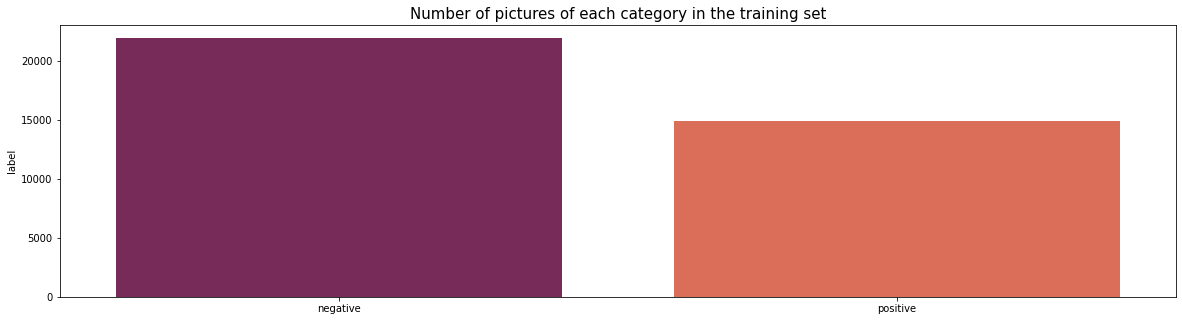

In [ ]:
# Display the number of pictures of each category in the training set
vc = trainPath_df['label'].value_counts()
plt.figure(figsize=(20,5))
sns.barplot(x = sorted(vc.index), y = vc, palette = "rocket")
plt.title("Number of pictures of each category in the training set", fontsize = 15)
plt.show()

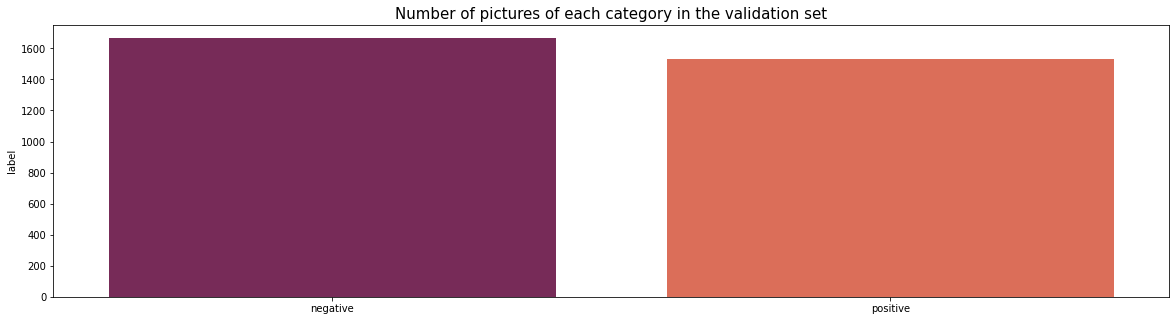

In [ ]:
# Display the number of pictures of each category in the training set
vc = valPath_df['label'].value_counts()
plt.figure(figsize=(20,5))
sns.barplot(x = sorted(vc.index), y = vc, palette = "rocket")
plt.title("Number of pictures of each category in the validation set", fontsize = 15)
plt.show()


In [ ]:
train_paths=trainPath_df.iloc[:,0]
valid_paths=valPath_df.iloc[:,0]

In [ ]:
# Convert to list
train_paths = train_paths.to_list()
valid_paths = valid_paths.to_list()

In [ ]:
def getCode(label):   # convert label to code
    return category[label]

In [ ]:
class_names =['XR_WRIST','XR_SHOULDER','XR_HAND','XR_FINGER','XR_ELBOW','XR_FOREARM','XR_HUMERUS']
category = {class_name:i for i, class_name in enumerate(class_names)}

# Preprocessing

In [ ]:
def Preprocessing(Data):
    x=[]
    y = []
    index=0
    for i in Data:
        print(f"Loading {Data[index]} ")
        # Preprocessing
        picture=cv2.imread(i)
        img=cv2.resize(picture,IMAGE_SIZE)
        img = img.astype('float32')
        img=img_to_array(img)

        #Normalization
        img /= 255.0
        #Manual Normalization
        #mean = np.mean(img)			
        #std = np.std(img)
        #img = (img - mean) / std
        
        # Select The category of Image
        currentLabel= str(Data[index])
        Label =Data[index].split('/')[4].split('_')[1]
        # Append to List
        x.append(img)

        if(Label =='positive'):
            y.append(1)
        else:
            y.append(0)

        index+=1
    x = np.array(x)  
    y = np.array(y)
    print(f'{len(x)} images loaded Sucessfully.')

    return x,y

In [ ]:
X_FINGER_train , y_FINGER_train  = Preprocessing(FINGER_train_paths)
X_FINGER_valid , y_FINGER_valid  = Preprocessing(FINGER_valid_paths)


Loading MURA-v1.1/train/XR_FINGER/patient03227/study1_positive/image1.png 
Loading MURA-v1.1/train/XR_FINGER/patient03227/study1_positive/image2.png 
Loading MURA-v1.1/train/XR_FINGER/patient03227/study1_positive/image3.png 
Loading MURA-v1.1/train/XR_FINGER/patient03228/study1_positive/image1.png 
Loading MURA-v1.1/train/XR_FINGER/patient03228/study1_positive/image2.png 
Loading MURA-v1.1/train/XR_FINGER/patient03228/study1_positive/image3.png 
Loading MURA-v1.1/train/XR_FINGER/patient03229/study1_positive/image1.png 
Loading MURA-v1.1/train/XR_FINGER/patient03229/study1_positive/image2.png 
Loading MURA-v1.1/train/XR_FINGER/patient03229/study1_positive/image3.png 
Loading MURA-v1.1/train/XR_FINGER/patient02370/study1_positive/image1.png 
Loading MURA-v1.1/train/XR_FINGER/patient02370/study1_positive/image2.png 
Loading MURA-v1.1/train/XR_FINGER/patient02370/study1_positive/image3.png 
Loading MURA-v1.1/train/XR_FINGER/patient02370/study2_positive/image1.png 
Loading MURA-v1.1/train/X

KeyboardInterrupt: ignored

# Save And Load Model 

In [ ]:
# For Save array to npy file
'''
with open('X_FOREARM_train.npy', 'wb') as f:
    np.save(f, X_FOREARM_train)

with open('y_FOREARM_train.npy', 'wb') as f:
    np.save(f, y_FOREARM_train)

#with open('X_FOREARM_valid.npy', 'wb') as f:
    np.save(f, X_FOREARM_valid)
#with open('y_FOREARM_valid.npy', 'wb') as f:
    np.save(f, y_FOREARM_valid)
'''

"\n#with open('X_FOREARM_valid.npy', 'wb') as f:\n    np.save(f, X_FOREARM_valid)\n#with open('y_FOREARM_valid.npy', 'wb') as f:\n    np.save(f, y_FOREARM_valid)\n"

In [ ]:
# For Save array to npy file
with open('X_SHOULDER_train.npy', 'wb') as f:
  np.save(f, X_SHOULDER_train)
with open('y_SHOULDER_train.npy', 'wb') as f:
    np.save(f, y_SHOULDER_train)
with open('X_SHOULDER_valid.npy', 'wb') as f:
  np.save(f, X_SHOULDER_valid)
with open('y_SHOULDER_valid.npy', 'wb') as f:
  np.save(f, y_SHOULDER_valid)

In [ ]:
# For Loading npy file to array
with open(r'/content/drive/MyDrive/AI/X_SHOULDER_train.npy', 'rb') as f:
   X_SHOULDER_train = np.load(f)
with open(r'/content/drive/MyDrive/AI/y_SHOULDER_label.npy', 'rb') as f:
   y_SHOULDER_label = np.load(f)
with open(r'/content/drive/MyDrive/AI/X_SHOULDER_valid.npy', 'rb') as f:
  X_SHOULDER_valid = np.load(f)
with open(r'/content/drive/MyDrive/AI/y_SHOULDER_valid.npy', 'rb') as f:
  y_SHOULDER_valid = np.load(f)

In [ ]:
with open(r'/content/drive/MyDrive/AI/X_FOREARM_train.npy', 'rb') as f:
   X_FOREARM_train = np.load(f)
with open(r'/content/drive/MyDrive/AI/y_FOREARM_train.npy', 'rb') as f:
   y_FOREARM_train = np.load(f)
with open(r'/content/drive/MyDrive/AI/X_FOREARM_valid.npy', 'rb') as f:
  X_FOREARM_valid = np.load(f)
with open(r'/content/drive/MyDrive/AI/y_FOREARM_valid.npy', 'rb') as f:
  y_FOREARM_valid = np.load(f)

In [ ]:
with open(r'/content/drive/MyDrive/AI/X_HUMERUS_train.npy', 'rb') as f:
   X_HUMERUS_train = np.load(f)
with open(r'/content/drive/MyDrive/AI/y_HUMERUS_train.npy', 'rb') as f:
   y_HUMERUS_train = np.load(f)
with open(r'/content/drive/MyDrive/AI/X_HUMERUS_valid.npy', 'rb') as f:
  X_HUMERUS_valid = np.load(f)
with open(r'/content/drive/MyDrive/AI/y_HUMERUS_valid.npy', 'rb') as f:
  y_HUMERUS_valid = np.load(f)

In [ ]:
with open(r'/content/drive/MyDrive/AI/X_Wrist_train.npy', 'rb') as f:
   X_Wrist_train = np.load(f)
with open(r'/content/drive/MyDrive/AI/y_Wrist_label.npy', 'rb') as f:
   y_Wrist_train = np.load(f)
with open(r'/content/drive/MyDrive/AI/X_Wrist_valid.npy', 'rb') as f:
  X_Wrist_valid = np.load(f)
with open(r'/content/drive/MyDrive/AI/y_Wrist_valid.npy', 'rb') as f:
  y_Wrist_valid = np.load(f)

In [ ]:
print('X_WRIST_train: ',X_Wrist_train.shape ,'\nX_WRIST_train size:',len(X_Wrist_train))
print('y_WRIST_valid: ',y_Wrist_valid.shape ,'\ny_WRIST_valid size:',len(y_Wrist_valid))


X_WRIST_train:  (9752, 224, 224, 3) 
X_WRIST_train size: 9752
y_WRIST_valid:  (658,) 
y_WRIST_valid size: 658


In [ ]:
X_FOREARM_train , y_FOREARM_label  = shuffle(X_FOREARM_train , y_FOREARM_label)
X_FOREARM_valid , y_FOREARM_valid  = shuffle(X_FOREARM_valid , y_FOREARM_valid)
X_FOREARM_test , y_FOREARM_test  = shuffle(X_FOREARM_train , y_FOREARM_label)

print('X_FORDARM_train: ',X_FOREARM_train.shape ,'\nX_FORDARM_train size:',len(X_FOREARM_train))
print('y_FORDARM_valid: ',y_FOREARM_valid.shape ,'\ny_FORDARM_valid size:',len(y_FOREARM_valid))


X_FORDARM_train:  (1825, 224, 224, 3) 
X_FORDARM_train size: 1825
y_FORDARM_valid:  (301,) 
y_FORDARM_valid size: 301


## HUMERUS

In [ ]:
X_HUMERAS_train , y_HUMERAS_label  = Preprocessing(HUMERUS_train_paths)
X_HUMERAS_valid , y_HUMERAS_valid  = Preprocessing(HUMERUS_valid_paths)
X_HUMERAS_test , y_HUMERAS_test  = Preprocessing(HUMERUS_test)

## WRIST

In [ ]:
#X_Wrist_train , y_Wrist_label  = Preprocessing(WRIST_train_paths)
X_Wrist_valid , y_Wrist_valid  = Preprocessing(WRIST_valid_paths)
#X_Wrist_test , y_Wrist_test  = Preprocessing(FOREARM_test)

# X_FOREARM_train , y_FOREARM_label  = shuffle(X_FOREARM_train , y_FOREARM_label)
# X_FOREARM_valid , y_FOREARM_valid  = shuffle(X_FOREARM_valid , y_FOREARM_valid)
# X_FOREARM_test , y_FOREARM_test  = shuffle(X_FOREARM_train , y_FOREARM_label)

Loading MURA-v1.1/valid/XR_WRIST/patient11185/study1_positive/image2.png 
Loading MURA-v1.1/valid/XR_WRIST/patient11185/study1_positive/image3.png 
Loading MURA-v1.1/valid/XR_WRIST/patient11185/study1_positive/image4.png 
Loading MURA-v1.1/valid/XR_WRIST/patient11186/study1_positive/image1.png 
Loading MURA-v1.1/valid/XR_WRIST/patient11186/study1_positive/image2.png 
Loading MURA-v1.1/valid/XR_WRIST/patient11186/study2_positive/image1.png 
Loading MURA-v1.1/valid/XR_WRIST/patient11186/study2_positive/image2.png 
Loading MURA-v1.1/valid/XR_WRIST/patient11186/study2_positive/image3.png 
Loading MURA-v1.1/valid/XR_WRIST/patient11186/study3_positive/image1.png 
Loading MURA-v1.1/valid/XR_WRIST/patient11186/study3_positive/image2.png 
Loading MURA-v1.1/valid/XR_WRIST/patient11186/study3_positive/image3.png 
Loading MURA-v1.1/valid/XR_WRIST/patient11187/study1_positive/image1.png 
Loading MURA-v1.1/valid/XR_WRIST/patient11188/study1_positive/image1.png 
Loading MURA-v1.1/valid/XR_WRIST/patie

# Data Augmantation


In [ ]:
datagen = ImageDataGenerator(rotation_range=30,
                            horizontal_flip=True
                             )   

In [ ]:

HAND_train_generator = datagen.flow( x = X_HAND_train ,y = y_HAND_train,shuffle=True)

HAND_valid_generator = datagen.flow( x= X_HAND_valid ,y =  y_HAND_valid,shuffle=True)
#SHOULDER_test_generator = datagen.flow( x= X_SHOULDER_test ,y =  y_SHOULDER_test)

#datagen.fit(X_SHOULDER_test,augment = True)
#datagen.fit(X_SHOULDER_train,augment = True)
#datagen.fit(X_SHOULDER_valid,augment = True)


In [ ]:
FINGER_train_generator = datagen.flow( x = X_FINGER_train ,y = y_FINGER_train,shuffle= True)

FINGER_valid_generator = datagen.flow( x= X_FINGER_valid ,y =  y_FINGER_valid,shuffle=True)


#datagen.fit(X_FINGER_valid,augment = True)
#datagen.fit(X_FINGER_train,augment = True)

In [ ]:

ELBOW_train_generator = datagen.flow( x = X_ELBOW_train ,y = y_ELBOW_train,shuffle=True)

ELBOW_valid_generator = datagen.flow( x= X_ELBOW_valid ,y =  y_ELBOW_valid,shuffle=True)


In [ ]:
HUMERUS_train_generator = datagen.flow(x = X_HUMERUS_train,
                                       y = y_HUMERUS_train
                                       ,shuffle =True
                                       ,seed= 22)


HUMERUS_valid_generator = datagen.flow( x= X_HUMERUS_valid ,
                                       y =  y_HUMERUS_valid,
                                       shuffle = True 
                                       ,seed = 22)

#STEP_PER_EPOCH = len(FOREARM_train_generator.x) // FOREARM_train_generator.batch_size


datagen.fit(X_HUMERUS_train,augment = True)
datagen.fit(X_HUMERUS_valid , augment = True)
#datagen.fit(X_HUMERAS_test,augment = True)


In [ ]:
datagen.fit(X_Shoulder_train,augment = True)
datagen.fit(X_Wrist_valid,augment = True)



Wrist_train_generator = datagen.flow( x = X_Wrist_train,y = y_Wrist_label, batch_size=BATCH_SIZE)

Wrist_valid_generator = datagen.flow( x= X_Wrist_valid ,y =  y_Wrist_valid,batch_size=1)

#FOREARM_test_generator = datagen.flow(X_FOREARM_test , y_FOREARM_test,batch_size=BATCH_SIZE)

STEP_PER_EPOCH = len(Wrist_train_generator.x) // Wrist_train_generator.batch_size


# Build Model


In [ ]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_loss',
                                            patience = 2, verbose=1,factor=0.3, min_lr=0.000001)
stop = EarlyStopping(monitor='val_loss', patience=15,
                     mode='auto', verbose=1, restore_best_weights=True)
checkpoint = ModelCheckpoint('FOREARM_DnsNet.h5',
                             monitor='val_loss', verbose=1, save_best_only=True, mode='min')

In [ ]:
def deep_model(backbone):
    base_model = backbone(input_shape=[224,224,3],weights='imagenet',include_top=False)
    base_model.trainable = False
    model = Sequential()
    model.add(base_model)
    model.add(BatchNormalization(axis=-1,center=True,scale=True))
    model.add(GlobalAveragePooling2D())
    model.add(Dropout(0.2))
    model.add(Dense(256,activation='relu'))
    #model.add(Dropout(0.5))
    model.add(Dense(1, activation = 'sigmoid'))
    base_model.summary()

    model.compile(optimizer=Adam(lr=0.0001),loss='binary_crossentropy',metrics=['acc','mse'])
    return model


In [ ]:
def build_model(backbone):
    base_model = backbone(input_shape=(None, None,3),
                             weights='imagenet',
                             include_top=False,
                             pooling='avg')

    x = base_model.output

    predictions = Dense(1,activation='sigmoid')(x)
    model = Model(inputs=base_model.input, outputs=predictions)
    return model


In [ ]:
base_model = DenseNet169(input_shape=[224,224,3],weights='imagenet',include_top=False) 
base_model.trainable = False

model = Sequential()
model.add(base_model)
model.add(GlobalAveragePooling2D())
model.add(Dropout(0.2))
model.add(Dense(256,activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation = 'sigmoid'))

#'binary_crossentropy' &  BinaryFocalLoss(gamma = 3)
model.compile(loss=BinaryFocalLoss(gamma = 3), optimizer='adam', metrics=['acc', 'mse'])
model.build((None,224,224,3))
model.summary()


Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
densenet169 (Functional)     (None, 7, 7, 1664)        12642880  
_________________________________________________________________
global_average_pooling2d_6 ( (None, 1664)              0         
_________________________________________________________________
dropout_6 (Dropout)          (None, 1664)              0         
_________________________________________________________________
dense_13 (Dense)             (None, 256)               426240    
_________________________________________________________________
dense_14 (Dense)             (None, 1)                 257       
Total params: 13,069,377
Trainable params: 426,497
Non-trainable params: 12,642,880
_________________________________________________________________


In [ ]:
##
BATCH_SIZE = 64
EPOCHS = 10

learning_rate_reduction = ReduceLROnPlateau(monitor='val_loss', patience = 1, verbose=1,factor=0.3, min_lr=0.000001)
stop = EarlyStopping(monitor='val_loss', patience=15, mode='min', verbose=1, restore_best_weights=True)
checkpoint = ModelCheckpoint(f'FINGER_mura_densnet.h5', monitor='val_loss', verbose=1, save_best_only=True, mode='auto')

#callbacks = [EarlyStopping(monitor='val_loss', patience=2),ModelCheckpoint(filepath='best_model_unfreezed.h5', monitor='val_acc', save_best_only=True)]
#model = deep_model(DenseNet169)
history = model.fit( FINGER_train_generator,
    validation_data = FINGER_valid_generator, 
    epochs  = EPOCHS,
    callbacks = [learning_rate_reduction,checkpoint,stop],
    workers=0,
    use_multiprocessing=False )

#[learning_rate_reduction,checkpoint,stop],


Epoch 1/10
160/160 [==============================] - 70s 439ms/step - loss: 0.0655 - acc: 0.7429 - mse: 0.2007 - val_loss: 0.0797 - val_acc: 0.6746 - val_mse: 0.2204

Epoch 00001: val_loss improved from inf to 0.07970, saving model to FINGER_mura_densnet.h5
Epoch 2/10
160/160 [==============================] - 70s 438ms/step - loss: 0.0658 - acc: 0.7370 - mse: 0.2010 - val_loss: 0.0799 - val_acc: 0.6920 - val_mse: 0.2197

Epoch 00002: val_loss did not improve from 0.07970
Epoch 3/10
 63/160 [==========>...................] - ETA: 38s - loss: 0.0651 - acc: 0.7550 - mse: 0.1999

KeyboardInterrupt: ignored

In [ ]:

BATCH_SIZE = 16
EPOCHS = 20

learning_rate_reduction = ReduceLROnPlateau(monitor='val_loss', patience = 1, verbose=1,factor=0.3, min_lr=0.000001)
stop = EarlyStopping(monitor='val_loss', patience=15, mode='min', verbose=1, restore_best_weights=True)
checkpoint = ModelCheckpoint(f'HUMERUS_DensNet3.h5', monitor='val_loss', verbose=1, save_best_only=True, mode='auto')

#callbacks = [EarlyStopping(monitor='val_loss', patience=2),ModelCheckpoint(filepath='best_model_unfreezed.h5', monitor='val_acc', save_best_only=True)]
#model = deep_model(DenseNet169)
history3 = model.fit( HUMERUS_train_generator,
    validation_data = HUMERUS_valid_generator, 
    epochs  = EPOCHS,
    callbacks = [learning_rate_reduction,checkpoint,stop],
    workers=0,
    use_multiprocessing=False )

#[learning_rate_reduction,checkpoint,stop],


Epoch 1/25
40/40 [==============================] - 73s 1s/step - loss: 0.2833 - acc: 0.6250 - mse: 0.2374 - val_loss: 0.1519 - val_acc: 0.6979 - val_mse: 0.1983

Epoch 00001: val_loss improved from inf to 0.15191, saving model to HUMERUS_DensNet.h5
Epoch 2/25
40/40 [==============================] - 49s 1s/step - loss: 0.1511 - acc: 0.7028 - mse: 0.2003 - val_loss: 0.1444 - val_acc: 0.7118 - val_mse: 0.1977

Epoch 00002: val_loss improved from 0.15191 to 0.14441, saving model to HUMERUS_DensNet.h5
Epoch 3/25
40/40 [==============================] - 49s 1s/step - loss: 0.1307 - acc: 0.7563 - mse: 0.1864 - val_loss: 0.1140 - val_acc: 0.8056 - val_mse: 0.1696

Epoch 00003: val_loss improved from 0.14441 to 0.11404, saving model to HUMERUS_DensNet.h5
Epoch 4/25
40/40 [==============================] - 49s 1s/step - loss: 0.1297 - acc: 0.7555 - mse: 0.1816 - val_loss: 0.1287 - val_acc: 0.7639 - val_mse: 0.1797

Epoch 00004: ReduceLROnPlateau reducing learning rate to 0.0003000000142492354.

In [ ]:
model12.evaluate(X_SHOULDER_valid,y_SHOULDER_valid)

18/18 [==============================] - 4s 112ms/step - loss: 0.1338 - acc: 0.7425 - mse: 0.1977


[0.13377238810062408, 0.7424511313438416, 0.19766171276569366]

In [ ]:
#
BATCH_SIZE = 64
EPOCHS = 20
model1 = build_model(DenseNet169)
model1.compile(loss ='binary_crossentropy', optimizer='adam', metrics=['acc', 'mse'])

history1 = model1.fit(FINGER_train_generator,
    validation_data = FINGER_valid_generator, 
    epochs  = EPOCHS,
    callbacks = [learning_rate_reduction,checkpoint,stop],
    workers=0,
    use_multiprocessing=False )

Epoch 1/20
160/160 [==============================] - 141s 773ms/step - loss: 0.6126 - acc: 0.6741 - mse: 0.2054 - val_loss: 1.6957 - val_acc: 0.5965 - val_mse: 0.3518

Epoch 00001: val_loss improved from inf to 1.69570, saving model to HAND_DnsNet.h5
Epoch 2/20
160/160 [==============================] - 118s 736ms/step - loss: 0.5773 - acc: 0.6947 - mse: 0.1950 - val_loss: 0.8544 - val_acc: 0.5401 - val_mse: 0.2736

Epoch 00002: val_loss improved from 1.69570 to 0.85442, saving model to HAND_DnsNet.h5
Epoch 3/20
160/160 [==============================] - 118s 738ms/step - loss: 0.5439 - acc: 0.7223 - mse: 0.1822 - val_loss: 0.8929 - val_acc: 0.7072 - val_mse: 0.2384

Epoch 00003: val_loss did not improve from 0.85442
Epoch 4/20
160/160 [==============================] - 118s 738ms/step - loss: 0.5344 - acc: 0.7270 - mse: 0.1787 - val_loss: 1.3464 - val_acc: 0.4707 - val_mse: 0.4239

Epoch 00004: ReduceLROnPlateau reducing learning rate to 0.0003000000142492354.

Epoch 00004: val_loss 

KeyboardInterrupt: ignored

In [ ]:
BATCH_SIZE = 16
EPOCHS = 25
model1 = build_model(DenseNet169)
model1.compile(loss=BinaryFocalLoss(gamma = 3), optimizer='adam', metrics=['acc', 'mse'])

history = model1.fit( HAND_train_generator,
    validation_data = HAND_valid_generator, 
    epochs  = EPOCHS,
    callbacks = [learning_rate_reduction,checkpoint,stop],
    workers=0,
    use_multiprocessing=False )

Epoch 1/25
174/174 [==============================] - 148s 764ms/step - loss: 0.1020 - acc: 0.6944 - mse: 0.2237 - val_loss: 0.9389 - val_acc: 0.5891 - val_mse: 0.3601

Epoch 00001: val_loss did not improve from 0.16382
Epoch 2/25
174/174 [==============================] - 129s 742ms/step - loss: 0.0785 - acc: 0.7249 - mse: 0.2141 - val_loss: 0.0904 - val_acc: 0.5804 - val_mse: 0.2447

Epoch 00002: val_loss improved from 0.16382 to 0.09045, saving model to FOREARM_mura_densnet.h5
Epoch 3/25
 68/174 [==========>...................] - ETA: 1:15 - loss: 0.0722 - acc: 0.7413 - mse: 0.2105

KeyboardInterrupt: ignored

In [ ]:
denseNet = DenseNet169(input_shape=(None, None,3),
                             weights='imagenet',
                             include_top=False,
                             pooling='avg')
model1 = build_model(ResNet152)

#model.compile(loss="binary_crossentropy", optimizer='adam', metrics=['acc', 'mse'])
model1.compile(loss=BinaryFocalLoss(gamma = 3), optimizer='adam', metrics=['acc', 'mse'])
checkpoint = ModelCheckpoint('FOREARM_DensNet169.h5', monitor='val_loss', verbose=1, save_best_only=True, mode='min')
STEP_PER_EPOCH = FOREARM_train_generator.x // BATCH_SIZE
'''
history_Wrist_DenseNet = model.fit(X_Wrist_train,y_Wrist_label,
    validation_data = (X_Wrist_valid,y_Wrist_valid), 
    epochs  = 15,
    validation_steps = len(X_Wrist_valid) // BATCH_SIZE,
    callbacks = [learning_rate_reduction,checkpoint,stop],
    workers=0,
    use_multiprocessing=False )
'''


In [ ]:

model1 = build_model(ResNet152)

#model.compile(loss="binary_crossentropy", optimizer='adam', metrics=['acc', 'mse'])
model.compile(loss=BinaryFocalLoss(gamma = 3), optimizer='adam', metrics=['acc', 'mse'])
checkpoint = ModelCheckpoint('ر_Resnet.h5', monitor='val_loss', verbose=1, save_best_only=True, mode='min')
STEP_PER_EPOCH = FOREARM_train_generator.x // BATCH_SIZE
'''
history_Wrist_DenseNet = model.fit(X_Wrist_train,y_Wrist_label,
    validation_data = (X_Wrist_valid,y_Wrist_valid), 
    epochs  = 15,
    validation_steps = len(X_Wrist_valid) // BATCH_SIZE,
    callbacks = [learning_rate_reduction,checkpoint,stop],
    workers=0,
    use_multiprocessing=False )
'''


'\nhistory_Wrist_DenseNet = model.fit(X_Wrist_train,y_Wrist_label,\n    validation_data = (X_Wrist_valid,y_Wrist_valid), \n    epochs  = 15,\n    validation_steps = len(X_Wrist_valid) // BATCH_SIZE,\n    callbacks = [learning_rate_reduction,checkpoint,stop],\n    workers=0,\n    use_multiprocessing=False )\n'

In [ ]:
history_HUMERUS_ResNet = model.fit(HUMERUS_train_generator,
    validation_data = HUMERUS_valid_generator, 
    epochs  = 50,
    validation_steps = len(HUMERUS_valid_generator.x) // BATCH_SIZE,
    callbacks = [learning_rate_reduction,checkpoint,stop],
    workers=0,
    use_multiprocessing=False )

In [ ]:
history_HUMERUS = model1.fit_generator(HUMERUS_train_generator,
    validation_data = HUMERUS_valid_generator, 
    epochs  = 15,
    validation_steps = len(HUMERUS_valid_generator.x) // BATCH_SIZE,
    callbacks = [learning_rate_reduction,checkpoint,stop],
    workers=0,
    use_multiprocessing=False )

In [ ]:
denseNet = DenseNet169(input_shape=(None, None,3),
                             weights='imagenet',
                             include_top=False,
                             pooling='avg')
model1 = build_model(denseNet)

model1.compile(loss=BinaryFocalLoss(gamma = 3), optimizer='adam', metrics=['acc', 'mse'])
checkpoint = ModelCheckpoint('Wrist_.h5', monitor='val_loss', verbose=1, save_best_only=True, mode='min')
STEP_PER_EPOCH = len(FOREARM_train_generator.x) // BATCH_SIZE

history_FOREARM_DenseNet = model1.fit(FOREARM_train_generator,
    validation_data =FOREARM_valid_generator, 
    epochs  = 10,
    validation_steps = len(FOREARM_valid_generator.x) // BATCH_SIZE,
    callbacks = [learning_rate_reduction,checkpoint,stop],
    workers=0,
    use_multiprocessing=False )


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
densenet169 (Functional)     (None, 1664)              12642880  
_________________________________________________________________
flatten_1 (Flatten)          (None, 1664)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 4096)              6819840   
_________________________________________________________________
dropout_2 (Dropout)          (None, 4096)              0         
_________________________________________________________________
dense_4 (Dense)              (None, 1000)              4097000   
_________________________________________________________________
dropout_3 (Dropout)          (None, 1000)              0         
_________________________________________________________________
dense_5 (Dense)              (None, 1)                

In [ ]:
model = build_model(DenseNet169)

model.compile(loss="binary_crossentropy", optimizer='adam', metrics=['acc', 'mse'])
#model.compile(loss=BinaryFocalLoss(gamma = 3), optimizer='adam', metrics=['acc', 'mse'])

STEP_PER_EPOCH = len(X_Wrist_train) // BATCH_SIZE

history_HUMERAS_V1 = model.fit(X_Wrist_train,
    y_Wrist_label,
    steps_per_epoch = len(X_Wrist_train) // BATCH_SIZE ,
    validation_data = (X_Wrist_valid,y_Wrist_valid), 
    epochs  = 8,
    callbacks = [learning_rate_reduction,checkpoint,stop],
    workers=0,
    use_multiprocessing=False 
)





Epoch 1/10
609/609 [==============================] - 119s 164ms/step - loss: 0.6376 - acc: 0.6695 - mse: 0.2171 - val_loss: 0.7905 - val_acc: 0.6444 - val_mse: 0.2553

Epoch 00001: val_loss improved from 17.59085 to 0.79045, saving model to HUMERAS.h5
Epoch 2/10
609/609 [==============================] - 96s 158ms/step - loss: 0.5101 - acc: 0.7565 - mse: 0.1682 - val_loss: 0.7839 - val_acc: 0.6246 - val_mse: 0.2567

Epoch 00002: val_loss improved from 0.79045 to 0.78388, saving model to HUMERAS.h5
Epoch 3/10
609/609 [==============================] - 96s 157ms/step - loss: 0.4743 - acc: 0.7822 - mse: 0.1531 - val_loss: 0.6470 - val_acc: 0.7067 - val_mse: 0.2096

Epoch 00003: val_loss improved from 0.78388 to 0.64695, saving model to HUMERAS.h5
Epoch 4/10
609/609 [==============================] - 96s 157ms/step - loss: 0.4426 - acc: 0.8034 - mse: 0.1408 - val_loss: 0.4758 - val_acc: 0.7827 - val_mse: 0.1547

Epoch 00004: val_loss improved from 0.64695 to 0.47583, saving model to HUMER

In [ ]:
history_WRIST = model.fit(X_Wrist_train,
    y_Wrist_label,
    steps_per_epoch = len(X_Wrist_train) // BATCH_SIZE ,
    validation_data = (X_Wrist_valid,y_Wrist_valid), 
    epochs  = 5,
    callbacks = [learning_rate_reduction,checkpoint,stop],
    workers=0,
    use_multiprocessing=False 
)

Epoch 1/5
304/304 [==============================] - 295s 971ms/step - loss: 0.1281 - acc: 0.9543 - mse: 0.0352 - val_loss: 0.4970 - val_acc: 0.8404 - val_mse: 0.1326

Epoch 00001: val_loss did not improve from 0.43734
Epoch 2/5
304/304 [==============================] - 295s 969ms/step - loss: 0.0845 - acc: 0.9714 - mse: 0.0227 - val_loss: 0.6736 - val_acc: 0.8374 - val_mse: 0.1448

Epoch 00002: val_loss did not improve from 0.43734
Epoch 3/5
154/304 [==============>...............] - ETA: 2:22 - loss: 0.0606 - acc: 0.9819 - mse: 0.0152

In [ ]:
model.save('FOREARM_CNN_69%.h5')

In [ ]:
history_FOREARM = model.fit(X_FOREARM_train,y_FOREARM_label, batch_size = BATCH_SIZE,
                                epochs  = 100
                                ,shuffle = True                                
                                ,validation_data = (X_FOREARM_valid, y_FOREARM_valid)
                                 ,callbacks = [learning_rate_reduction,checkpoint,stop])

In [ ]:
test_loss, test_score  = model.evaluate(X_Wrist_valid,y_Wrist_valid)
print("Loss on test set: ", test_loss)
print("Accuracy on test set: ", test_score)

21/21 [==============================] - 3s 8ms/step - loss: 0.0000e+00 - acc: 0.0000e+00 - mse: 0.0000e+00


ValueError: ignored

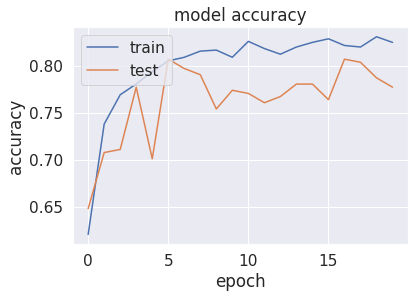

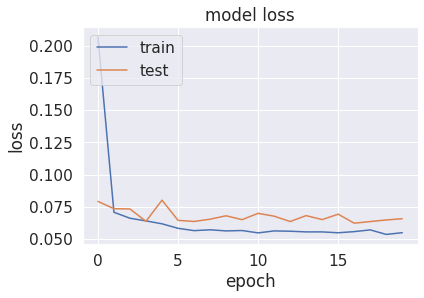

In [ ]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# Build Model

## Transfer Learning

In [ ]:

model = build_deep_model(DenseNet169())


model.compile(loss=BinaryFocalLoss(gamma = 4), optimizer='adam', metrics=['acc', 'mse'])

history_FOREARM = model.fit(FOREARM_train_generator,
    validation_data = FOREARM_valid_generator, 
    epochs  = 20,
    validation_steps = len(FOREARM_valid_generator.x) // BATCH_SIZE,
    callbacks = [learning_rate_reduction,checkpoint,stop],
    workers=0,
    use_multiprocessing=False )

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
densenet169 (Functional)     (None, 1000)              14307880  
_________________________________________________________________
flatten_6 (Flatten)          (None, 1000)              0         
_________________________________________________________________
batch_normalization_12 (Batc (None, 1000)              4000      
_________________________________________________________________
dropout_12 (Dropout)         (None, 1000)              0         
_________________________________________________________________
batch_normalization_13 (Batc (None, 1000)              4000      
_________________________________________________________________
dropout_13 (Dropout)         (None, 1000)              0         
_________________________________________________________________
batch_normalization_14 (Batc (None, 1000)             

KeyboardInterrupt: ignored

In [ ]:
model169.save('FOREARM_DenseNet169_80%.h5')

In [ ]:
history = deep_model(AlexN).fit_generator(datagen.flow(X_FOREARM_train,y_FOREARM_label),
    validation_data = (X_FOREARM_valid,y_FOREARM_valid ), 
    epochs  = 50,shuffle= True,callbacks = [learning_rate_reduction,checkpoint,stop],verbose = 1)

In [ ]:
def build_model(base_model):  # backbone mean the keras model 

    for layer in base_model.layers:
        layer.trainable = False

    x = base_model.output
    x = Dense(128, activation='relu')(x) 

    predictions = Dense(len(class_names), activation='softmax')(x) 
    
    model = Model(inputs=base_model.input, outputs=predictions)

    model.compile('adam', loss='categorical_crossentropy', metrics=['accuracy'])

    model.summary()
    #model.save('ML_finalproject_for 'backbone' model.h5")

    return model

In [ ]:
denseNet121 = DenseNet169(input_shape=[224,224,3],weights='imagenet',include_top=False)
denseNet121.summary()
for layers in denseNet121.layers[:50]:
    layers.trainable=False
x = Flatten()(denseNet121.output)
prediction = Dense(1, activation='sigmoid')(x)
# # create a model object
model = Model(inputs=denseNet121.input, outputs=prediction)
model.compile(optimizer=Adam(lr=0.001),loss='binary_crossentropy',metrics=['acc'])


# history_FOREARM_denseNet121_TR = model.fit_generator(train_generator,
#     validation_data = validation_generator, epochs  = 50,shuffle= True,callbacks = [learning_rate_reduction,checkpoint,stop],verbose = 1)
history_FOREARM_denseNet121_TR = model.fit_generator(datagen.flow(X_HUMERAS_train,y_HUMERAS_label),
    validation_data = (X_HUMERAS_valid,y_HUMERAS_valid ), 
    epochs  = 50,shuffle= True,callbacks = [learning_rate_reduction,checkpoint,stop],verbose = 1)

Model: "densenet121"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
zero_padding2d_10 (ZeroPadding2 (None, 230, 230, 3)  0           input_6[0][0]                    
__________________________________________________________________________________________________
conv1/conv (Conv2D)             (None, 112, 112, 64) 9408        zero_padding2d_10[0][0]          
__________________________________________________________________________________________________
conv1/bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1/conv[0][0]                 
________________________________________________________________________________________

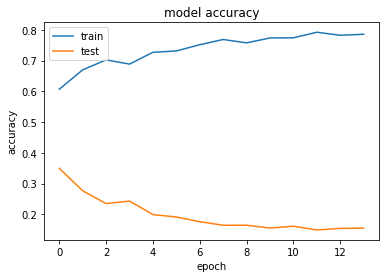

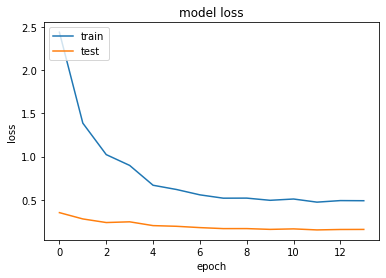

In [ ]:
plt.title('history_FOREARM_TR')
plt.plot(history_FOREARM.history['acc'])
plt.plot(history_FOREARM.history['mse'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history_FOREARM.history['loss'])
plt.plot(history_FOREARM.history['mse'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
vgg16 = VGG16(input_shape=[224,224,3],weights='imagenet',include_top=False)
vgg16.summary()


model = Sequential()
model.add(vgg16)
model.add(GlobalAveragePooling2D())
model.add(Dropout(0.5))
model.add(Dense(512))
model.add(Dropout(0.5))
model.add(Dense(1, activation = 'sigmoid'))
model.compile(optimizer = 'adam', loss = 'binary_crossentropy',
                           metrics = ['acc'])
model.summary()
# model=Sequential()
# model.add(vgg16)

# model.add(Dense(256,activation='relu'))
# model.add(Dense(1,activation='softmax'))

datagen = ImageDataGenerator(  # apply ZCA whitening
        rotation_range=30,    # randomly shift images vertically (fraction of total height)
        horizontal_flip=True,  # randomly flip images
       ) 


datagen.fit(X_FOREARM_train)

epochs=50
red_lr=ReduceLROnPlateau(monitor='val_acc', factor=0.1, epsilon=0.0001, patience=2, verbose=1)


# vgg16.trainable=False # setting the VGG model to be untrainable.
# model.compile(optimizer=Adam(lr=1e-4),loss='binary_crossentropy',metrics=['accuracy'])
History = vgg16_model.fit_generator(datagen.flow(train_generator, batch_size=BATCH_SIZE),
                              epochs = 50, validation_data = validation_generator,
                              verbose = 1)



58892288/58889256 [==============================] - 0s 0us/step
Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
______________________________________________________________

NameError: ignored

In [ ]:
resaults = model.evaluate(X_FOREARM_valid,y_FOREARM_valid)
resaults

10/10 [==============================] - 1s 109ms/step - loss: 0.9213 - acc: 0.6146 - mse: 0.2943


[0.9213247895240784, 0.6146179437637329, 0.2942628264427185]

In [ ]:
def create_model():
    img_input = Input(shape=(224, 224, 3))

    # Block 1
    x = Conv2D(filters=64, kernel_size=(3, 3), padding='same', activation='relu', name='block1_conv1', trainable=False)(img_input)
    x = Conv2D(filters=64, kernel_size=(3, 3), padding='same', activation='relu', name='block1_conv2', trainable=False)(x)
    x = MaxPooling2D(pool_size=(2,2), strides=(2,2), padding='valid', name='block1_pool', trainable=False)(x)

    #Block 2
    x = Conv2D(filters=128, kernel_size=(3,3), padding='same', activation='relu', name='block2_conv1',trainable=False)(x)
    x = Conv2D(filters=128, kernel_size=(3,3), padding='same', activation='relu', name='block2_conv2', trainable=False)(x)
    x = MaxPooling2D(pool_size=(2,2), strides=(2,2), padding='valid', name='block2_pool', trainable=False)(x)

    #Block 3
    x = Conv2D(filters=256, kernel_size=(3,3), padding='same', activation='relu', name='block3_conv1',trainable=False)(x)
    x = Conv2D(filters=256, kernel_size=(3,3), padding='same', activation='relu', name='block3_conv2', trainable=False)(x)
    x = Conv2D(filters=256, kernel_size=(3,3), padding='same', activation='relu', name='block3_conv3', trainable=False)(x)
    x = Conv2D(filters=256, kernel_size=(3,3), padding='same', activation='relu', name='block3_conv4', trainable=False)(x)
    x = MaxPooling2D(pool_size=(2,2), strides=(2,2), padding='valid', name='block3_pool', trainable=False)(x)

    #Block 4
    x = Conv2D(filters=512, kernel_size=(3,3), padding='same', activation='relu', name='block4_conv1')(x)
    x = BatchNormalization(name='block4_bn1')(x)
    x = Conv2D(filters=512, kernel_size=(3,3), padding='same', activation='relu', name='block4_conv2')(x)
    x = BatchNormalization(name='block4_bn2')(x)
    x = Conv2D(filters=512, kernel_size=(3,3), padding='same', activation='relu', name='block4_conv3')(x)
    x = BatchNormalization(name='block4_bn3')(x)
    x = Conv2D(filters=512, kernel_size=(3,3), padding='same', activation='relu', name='block4_conv4')(x)
    x = MaxPooling2D(pool_size=(2,2), strides=(2,2), padding='valid', name='block4_pool')(x)

    #Block 5
    x = Conv2D(filters=512, kernel_size=(3,3), padding='same', activation='relu', name='block5_conv1')(x)
    x = BatchNormalization(name='block5_bn1')(x)
    x = Conv2D(filters=512, kernel_size=(3,3), padding='same', activation='relu', name='block5_conv2')(x)
    x = BatchNormalization(name='block5_bn2')(x)
    x = Conv2D(filters=512, kernel_size=(3,3), padding='same', activation='relu', name='block5_conv3')(x)
    x = BatchNormalization(name='block5_bn3')(x)
    x = Conv2D(filters=512, kernel_size=(3,3), padding='same', activation='relu', name='block5_conv4')(x)
    x = MaxPooling2D(pool_size=(2,2), strides=(2,2), padding='valid', name='block5_pool')(x)
    
    #Other layers
    x = Flatten(name='flatten')(x)
    x = Dense(4096, activation='relu', name='fc1')(x)
    x = Dropout(0.7, name='dropout_1')(x)
    x = Dense(1000, activation='relu', name='fc2')(x)
    x = Dropout(0.7, name='dropout_2')(x)
    x = Dense(512, activation='relu', name='fc3')(x)
    x = Dropout(0.5, name='dropout_3')(x)
    x = Dense(1, activation='sigmoid', name='predictions')(x)
    
    model = Model(inputs=img_input, outputs=x)
    return model
base_model = VGG19(weights='imagenet', include_top=False)

80142336/80134624 [==============================] - 1s 0us/step


In [ ]:
model = create_model()
model.summary()
layer_count = 0
for layer in model.layers:
    if layer.name[:6] in ['block1', 'block2', 'block3']:
        model.layers[layer_count].set_weights = base_model.layers[layer_count].get_weights()
    layer_count += 1
adam = Adam()
model.compile(loss='binary_crossentropy', metrics=['accuracy'], optimizer=adam)
reduce_lr = ReduceLROnPlateau(monitor='val_acc', 
                                patience=3, 
                                verbose=1, 
                                factor=0.2, 
                                min_lr=1e-7)
model_chkpoint = ModelCheckpoint(filepath='vgg_19_best_model', save_best_only=True, save_weights_only=True)

model.fit((X_SHOULDER_train,y_SHOULDER_label),
                    validation_data = (X_SHOULDER_valid,y_SHOULDER_valid),
                    epochs=20,
                    callbacks=[reduce_lr, model_chkpoint] )

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0   

ValueError: ignored

In [ ]:
X_SHOULDER_train.shape

(8378, 224, 224, 3)

In [ ]:
def build_model():
    base_model = DenseNet121(input_shape=(None, None,3),
                             weights='imagenet',
                             include_top=False,
                             pooling='avg')
#     i = 0
#     total_layers = len(base_model.layers)
#     for layer in base_model.layers:
#         if(i <= total_layers//2):
#             layer.trainable = True
#             i = i+1

    x = base_model.output
    predictions = Dense(1,activation='sigmoid')(x)
    model = Model(inputs=base_model.input, outputs=predictions)
    return model

model = build_model()

#Compiling the model
model.compile(loss="binary_crossentropy", optimizer='adam', metrics=['acc', 'mse'])

#callbacks for early stopping incase of reduced learning rate, loss unimprovement
early_stop = EarlyStopping(monitor='val_loss', patience=8, verbose=1, min_delta=1e-4)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=1, verbose=1, min_lr=0.0001)
callbacks_list = [early_stop, reduce_lr]
#train the module
model_history = model.fit_generator(
    FOREARM_train_generator,
    steps_per_epoch =len(X_FOREARM_train)//BATCH_SIZE,
    epochs=6,
    workers=0,
    use_multiprocessing=False,  
    validation_data= FOREARM_valid_generator,
    validation_steps = len(X_FOREARM_valid) // BATCH_SIZE,
    callbacks=callbacks_list)

29089792/29084464 [==============================] - 0s 0us/step
Epoch 1/6
57/57 [==============================] - 78s 1s/step - loss: 0.7209 - acc: 0.6577 - mse: 0.2378 - val_loss: 39.3113 - val_acc: 0.4444 - val_mse: 0.5556
Epoch 2/6
57/57 [==============================] - 58s 1s/step - loss: 0.5331 - acc: 0.7724 - mse: 0.1707 - val_loss: 1.5196 - val_acc: 0.4444 - val_mse: 0.4281
Epoch 3/6
57/57 [==============================] - 58s 1s/step - loss: 0.4616 - acc: 0.7900 - mse: 0.1481 - val_loss: 9.1806 - val_acc: 0.3333 - val_mse: 0.6667

Epoch 00003: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
Epoch 4/6
57/57 [==============================] - 58s 1s/step - loss: 0.4145 - acc: 0.8268 - mse: 0.1296 - val_loss: 0.2211 - val_acc: 0.8889 - val_mse: 0.0784
Epoch 5/6
57/57 [==============================] - 59s 1s/step - loss: 0.4106 - acc: 0.8311 - mse: 0.1273 - val_loss: 0.3226 - val_acc: 0.8889 - val_mse: 0.1063

Epoch 00005: ReduceLROnPlateau reducing learni

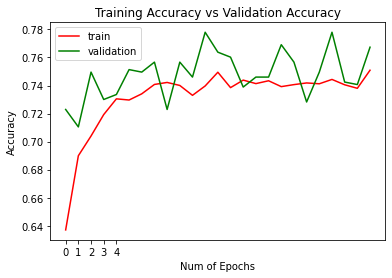

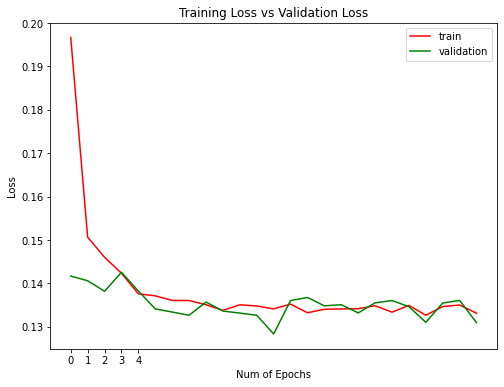

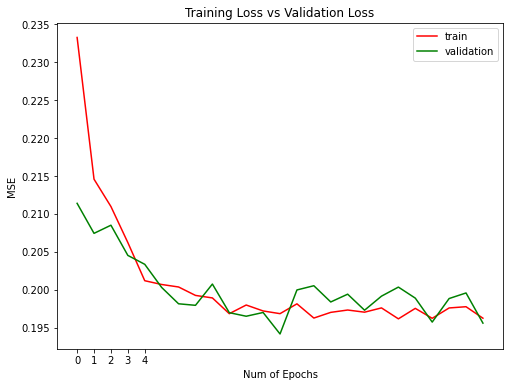

In [ ]:
#Now we have trained our model, we can see the metrics during the training proccess
plt.figure(0)
plt.plot(history12.history['acc'],'r')
plt.plot(history12.history['val_acc'],'g')
plt.xticks(np.arange(0, 5, 1))
plt.rcParams['figure.figsize'] = (8, 6)
plt.xlabel("Num of Epochs")
plt.ylabel("Accuracy")
plt.title("Training Accuracy vs Validation Accuracy")
plt.legend(['train','validation'])
 
plt.figure(1)
plt.plot(history12.history['loss'],'r')
plt.plot(history12.history['val_loss'],'g')
plt.xticks(np.arange(0, 5, 1))
plt.rcParams['figure.figsize'] = (8, 6)
plt.xlabel("Num of Epochs")
plt.ylabel("Loss")
plt.title("Training Loss vs Validation Loss")
plt.legend(['train','validation'])

plt.figure(2)
plt.plot(history12.history['mse'],'r')
plt.plot(history12.history['val_mse'],'g')
plt.xticks(np.arange(0, 5, 1))
plt.rcParams['figure.figsize'] = (8, 6)
plt.xlabel("Num of Epochs")
plt.ylabel("MSE")
plt.title("Training Loss vs Validation Loss")
plt.legend(['train','validation'])
 
plt.show()

In [ ]:
checkpoint = ModelCheckpoint('FOREARM_InceptionV3_CNN.h5', monitor='val_loss', verbose=1, save_best_only=True, mode='auto')


# a

In [ ]:
HUMERUS_model = load_model('/content/HUMERUS_DensNet.h5')
pic = '/content/MURA-v1.1/valid/XR_HUMERUS/patient11214/study1_positive/image2.png'
def prepare(filepath):
    IMG_SIZE=224
    img_arr=cv2.imread(filepath)
    img_arr = img_arr/255.0
    new_arr=cv2.resize(img_arr,(IMG_SIZE,IMG_SIZE))
    return new_arr.reshape(-1,IMG_SIZE,IMG_SIZE,3)

prediction = HUMERUS_model.predict_generator(prepare(pic))
print(prediction)

ValueError: ignored

# Generate new Data


In [ ]:
image_path = '/content/MURA-v1.1/valid/XR_SHOULDER/patient11717/study1_positive/image1.png'
image_name = image_path.split('/')[4]
makedirs(f'/content/{image_name}')
save_here = f'/content/{image_name}'

In [ ]:
datagen = ImageDataGenerator(rotation_range=10,
                            width_shift_range=0.1,
                            height_shift_range=0.1,
                            shear_range=0.15,
                            zoom_range=0.1,
                            channel_shift_range = 10,
                            horizontal_flip=True)

In [ ]:
image = np.expand_dims(cv2.imread(image_path), 0)

In [ ]:
# picture=cv2.imread(image_path)
# img=cv2.resize(picture,(224,224))
# img = img.astype('float32')
#img=img_to_array(img)

In [ ]:
datagen.fit(image)

In [ ]:
for x, val in zip(datagen.flow(image,                    #image we chose
        save_to_dir=save_here,     #this is where we figure out where to save
        save_prefix=f'aug_{image_name}',        # it will save the images as 'aug_0912' some number for every new augmented image
        save_format='png'),range(10)) :     # here we define a range because we want 10 augmented images otherwise it will keep looping forever I think
    pass

# Load Models

In [ ]:
model = load_model('/content/drive/MyDrive/AI/H5/SHOULDER_DensNet.h5')

In [ ]:
model.evaluate(SHOULDER_valid_generator)

18/18 [==============================] - 42s 423ms/step - loss: 0.0606 - acc: 0.7780 - mse: 0.1883


[0.06060740724205971, 0.7779751420021057, 0.18832096457481384]

# Resaults


## Evaluation

### Confusion Matric

In [ ]:
model1 = load_model('/content/drive/MyDrive/FINGER_mura_densnet.h5')

ValueError: ignored

In [ ]:
ev = model.evaluate(FINGER_valid_generator,  workers=0, use_multiprocessing=False)


15/15 [==============================] - 7s 502ms/step - loss: 0.6406 - acc: 0.6443


In [ ]:
ev = model.evaluate(SHOULDER_train_generator,  workers=0, use_multiprocessing=False)
ev[1]

#pred = model.predict_generator(validation_generator, steps=1, batch_size=1, use_multiprocessing=False, max_queue_size=25, verbose=1)
#FOREARM_valid_generator.reset()
#pred = model.predict_generator(validation_generator,steps=nb_validation_samples)
pred_batch = model.predict_on_batch(SHOULDER_train_generator.x)
pred_batch
predictions = []
for p in pred_batch:
    if(p > 0.5):
        predictions+=[1]
    else:
        predictions+=[0]
        
error = np.sum(np.not_equal(predictions, SHOULDER_train_generator.y)) / SHOULDER_train_generator.y.shape[0]  
pred = predictions 

print('Confusion Matrix')
from sklearn.metrics import confusion_matrix, classification_report, cohen_kappa_score
import seaborn as sn
cm = confusion_matrix( pred , SHOULDER_train_generator.y)
plt.figure(figsize = (30,20))
sn.set(font_scale=1.4) #for label size
sn.heatmap(cm, annot=True, annot_kws={"size": 20},cmap="YlGnBu") # font size
plt.show()

262/262 [==============================] - 142s 411ms/step - loss: 0.0609 - acc: 0.7866 - mse: 0.1874


In [ ]:
ev = model.evaluate(X_Wrist_train,y_Wrist_train,  workers=0, use_multiprocessing=False)
ev[1]

#pred = model.predict_generator(validation_generator, steps=1, batch_size=1, use_multiprocessing=False, max_queue_size=25, verbose=1)
#FOREARM_valid_generator.reset()
#pred = model.predict_generator(validation_generator,steps=nb_validation_samples)
pred_batch = model.predict_on_batch(X_Wrist_train)
pred_batch
predictions = []
for p in pred_batch:
    if(p > 0.5):
        predictions+=[1]
    else:
        predictions+=[0]
        
error = np.sum(np.not_equal(predictions, y_Wrist_train)) / y_Wrist_train.shape[0]  
pred = predictions 

print('Confusion Matrix')
from sklearn.metrics import confusion_matrix, classification_report, cohen_kappa_score
import seaborn as sn
cm = confusion_matrix( pred , y_Wrist_train)
plt.figure(figsize = (30,20))
sn.set(font_scale=1.4) #for label size
sn.heatmap(cm, annot=True, annot_kws={"size": 20},cmap="YlGnBu") # font size
plt.show()

305/305 [==============================] - 38s 126ms/step - loss: 0.3201 - acc: 0.8706 - mse: 0.0963


In [ ]:
ev = model.evaluate(X_Wrist_train,y_Wrist_train,  workers=0, use_multiprocessing=False)
ev[1]

#pred = model.predict_generator(validation_generator, steps=1, batch_size=1, use_multiprocessing=False, max_queue_size=25, verbose=1)
#FOREARM_valid_generator.reset()
#pred = model.predict_generator(validation_generator,steps=nb_validation_samples)
pred_batch = model.predict_on_batch(X_Wrist_train)
pred_batch
predictions = []
for p in pred_batch:
    if(p > 0.5):
        predictions+=[1]
    else:
        predictions+=[0]
        
error = np.sum(np.not_equal(predictions, y_Wrist_train)) / y_Wrist_train.shape[0]  
pred = predictions 

print('Confusion Matrix')
from sklearn.metrics import confusion_matrix, classification_report, cohen_kappa_score
import seaborn as sn
cm = confusion_matrix( pred , y_Wrist_train)
plt.figure(figsize = (30,20))
sn.set(font_scale=1.4) #for label size
sn.heatmap(cm, annot=True, annot_kws={"size": 20},cmap="YlGnBu") # font size
plt.show()

NameError: ignored

10/10 [==============================] - 1s 111ms/step - loss: 0.0626 - acc: 0.7907 - mse: 0.1919
Confusion Matrix


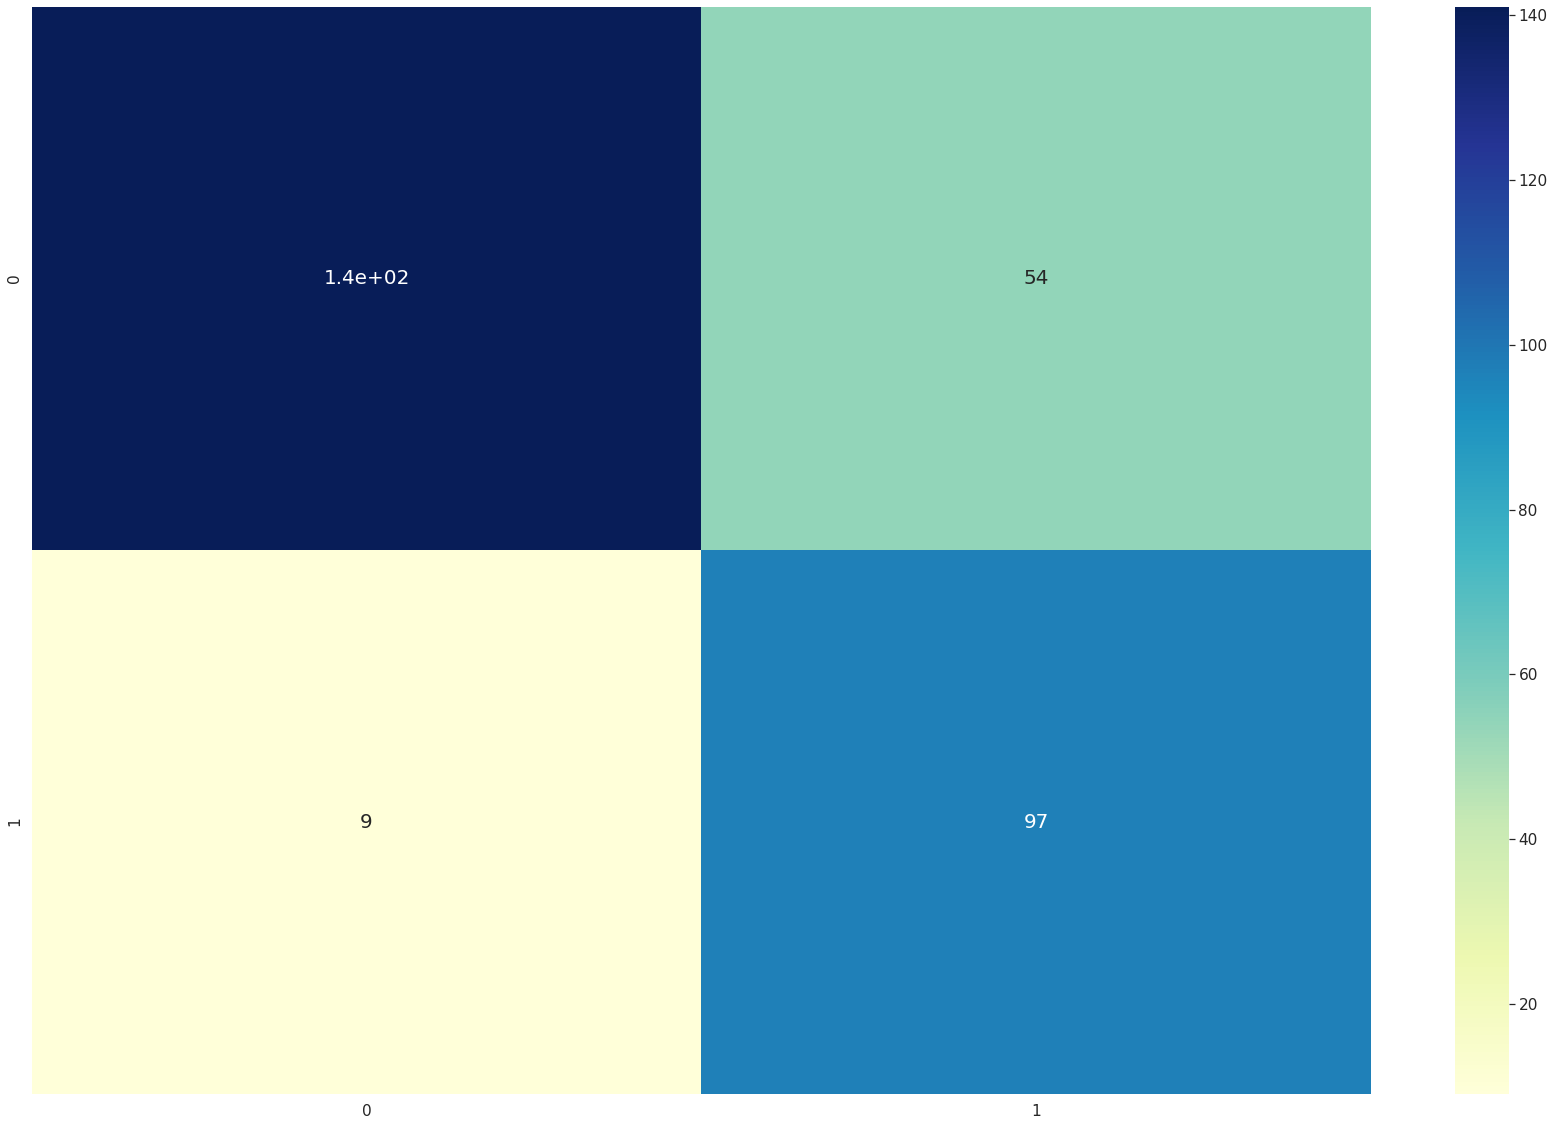

In [ ]:
ev = model.evaluate(FOREARM_valid_generator.x,FOREARM_valid_generator.y,  workers=0, use_multiprocessing=False)
ev[1]

#pred = model.predict_generator(validation_generator, steps=1, batch_size=1, use_multiprocessing=False, max_queue_size=25, verbose=1)
#FOREARM_valid_generator.reset()
#pred = model.predict_generator(validation_generator,steps=nb_validation_samples)
pred_batch = model.predict_on_batch(FOREARM_valid_generator.x)
pred_batch
predictions = []
for p in pred_batch:
    if(p > 0.5):
        predictions+=[1]
    else:
        predictions+=[0]
        
error = np.sum(np.not_equal(predictions, FOREARM_valid_generator.y)) / FOREARM_valid_generator.y.shape[0]  
pred = predictions 

print('Confusion Matrix')
from sklearn.metrics import confusion_matrix, classification_report, cohen_kappa_score
import seaborn as sn
cm = confusion_matrix( pred ,FOREARM_valid_generator.y)
plt.figure(figsize = (30,20))
sn.set(font_scale=1.4) #for label size
sn.heatmap(cm, annot=True, annot_kws={"size": 20},cmap="YlGnBu") # font size
plt.show()

In [ ]:
ev = model.evaluate(FOREARM_train_generator.x,FOREARM_train_generator.y,  workers=0, use_multiprocessing=False)
ev[1]

#pred = model.predict_generator(validation_generator, steps=1, batch_size=1, use_multiprocessing=False, max_queue_size=25, verbose=1)
#FOREARM_valid_generator.reset()
#pred = model.predict_generator(validation_generator,steps=nb_validation_samples)
pred_batch = model.predict_on_batch(FOREARM_train_generator.x)
pred_batch
predictions = []
for p in pred_batch:
    if(p > 0.5):
        predictions+=[1]
    else:
        predictions+=[0]
        
error = np.sum(np.not_equal(predictions, FOREARM_train_generator.y)) / FOREARM_train_generator.y.shape[0]  
pred = predictions 

print('Confusion Matrix')
from sklearn.metrics import confusion_matrix, classification_report, cohen_kappa_score
import seaborn as sn
cm = confusion_matrix( pred ,FOREARM_train_generator.y)
plt.figure(figsize = (30,20))
sn.set(font_scale=1.4) #for label size
sn.heatmap(cm, annot=True, annot_kws={"size": 20},cmap="YlGnBu") # font size
plt.show()

### Kappa score

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report, cohen_kappa_score
cohen_kappa_score(FOREARM_valid_generator.y, pred)

0.5818061528283163

### Classification report

In [ ]:
print()
print('Classification Report')
print(classification_report(FOREARM_valid_generator.y, pred, target_names=["0","1"]))


Classification Report
              precision    recall  f1-score   support

           0       0.72      0.94      0.82       150
           1       0.92      0.64      0.75       151

    accuracy                           0.79       301
   macro avg       0.82      0.79      0.79       301
weighted avg       0.82      0.79      0.79       301



### ROC score

In [ ]:
from sklearn.metrics import roc_curve
fpr_keras, tpr_keras, thresholds_keras = roc_curve(FOREARM_valid_generator.y, pred_batch)

In [ ]:
from sklearn.metrics import auc
auc_keras = auc(fpr_keras, tpr_keras)
auc_keras

0.8810596026490067

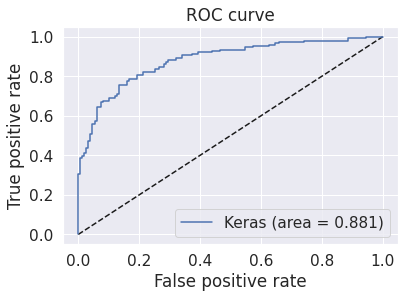

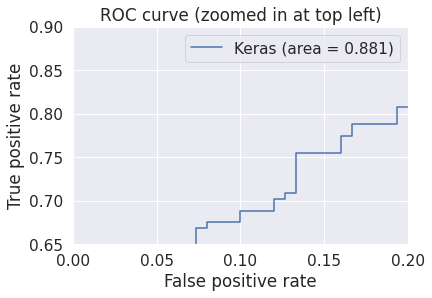

In [ ]:
plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_keras, tpr_keras, label='Keras (area = {:.3f})'.format(auc_keras))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

plt.figure(2)
plt.xlim(0.0, 0.2)
plt.ylim(0.65, 0.9)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_keras, tpr_keras, label='Keras (area = {:.3f})'.format(auc_keras))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve (zoomed in at top left)')
plt.legend(loc='best')
plt.show()

### Performance Evaluation

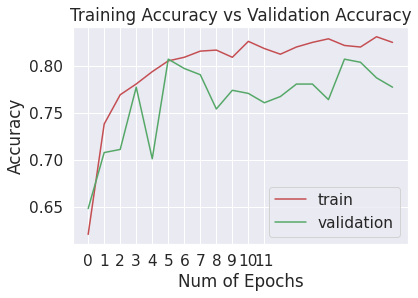

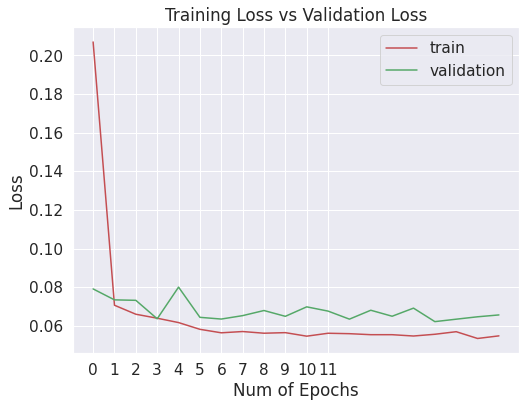

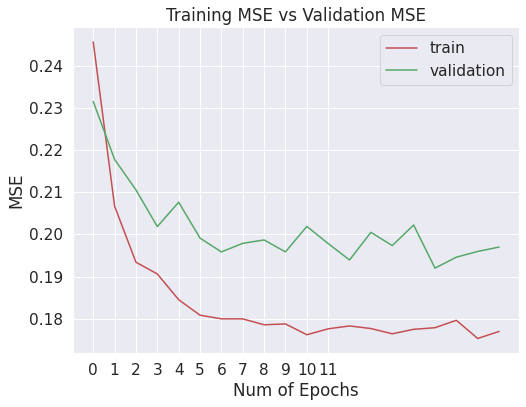

In [ ]:

#Now we have trained our model, we can see the metrics during the training proccess
plt.figure(0)
plt.plot(history.history['acc'],'r')
plt.plot(history.history['val_acc'],'g')
plt.xticks(np.arange(0, 12, 1))
plt.rcParams['figure.figsize'] = (8, 6)
plt.xlabel("Num of Epochs")
plt.ylabel("Accuracy")
plt.title("Training Accuracy vs Validation Accuracy")
plt.legend(['train','validation'])
 
plt.figure(1)
plt.plot(history.history['loss'],'r')
plt.plot(history.history['val_loss'],'g')
plt.xticks(np.arange(0, 12, 1))
plt.rcParams['figure.figsize'] = (8, 6)
plt.xlabel("Num of Epochs")
plt.ylabel("Loss")
plt.title("Training Loss vs Validation Loss")
plt.legend(['train','validation'])

plt.figure(2)
plt.plot(history.history['mse'],'r')
plt.plot(history.history['val_mse'],'g')
plt.xticks(np.arange(0, 12, 1))
plt.rcParams['figure.figsize'] = (8, 6)
plt.xlabel("Num of Epochs")
plt.ylabel("MSE")
plt.title("Training MSE vs Validation MSE")
plt.legend(['train','validation'])
 
plt.show()


# slihfso

In [ ]:
/content/MURA-v1.1/valid/XR_SHOULDER/patient11722/study1_positive/image1.png

#Prediction 

Enter the Category 	elbow
Input the Image 	/content/MURA-v1.1/valid/XR_ELBOW/patient11238/study1_negative/image1.png
Processing...
[[0.09478789]]
This image is  NORMAL


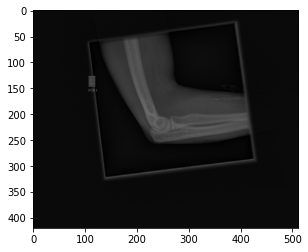

In [ ]:
## one input and data type one outout
class_input=input(f"Enter the Category \t")
image= input(f"Input the Image \t")
class_names =['wrist','shoulder','hand','finger','elbow','forearm','humerus']
index = 0
models = ['/content/drive/MyDrive/AI/H5/Wrist.h5',
          '/content/drive/MyDrive/AI/H5/SHOULDER_DensNet.h5',
          '/content/drive/MyDrive/AI/H5/Hand_Den169.h5',
          '/content/drive/MyDrive/AI/H5/FINGER_dansenet169.h5',
          '/content/drive/MyDrive/AI/H5/ELBOW_dansenet169_mura.h5',
          '/content/drive/MyDrive/AI/H5/FOREARM_DenseNet169_80%.h5',
          '/content/drive/MyDrive/AI/H5/HUMERUS_DensNet169.h5'
          ]

def prepare(filepath):
    IMG_SIZE=224
    img_arr=cv2.imread(filepath)
    img_arr = img_arr / 255.0
    new_arr=cv2.resize(img_arr,(IMG_SIZE,IMG_SIZE))
    return new_arr.reshape(-1,IMG_SIZE,IMG_SIZE,3)


for i in class_names:
    index = 0
    if class_input == i:
        print('Processing...')
        model =load_model(models[index])
        class_predict= model.predict(prepare(image))
        print(class_predict)
        plt.imshow(cv2.imread(image))
        if class_predict>= 0.5:
            stat = class_predict[0] * 100 
            print(f"This image  ABNORMAL")

        else:
            stat = class_predict[0] * 100 
            print(f"This image is  NORMAL")
           
        index+=1
    else:
        pass

Input the Image 	/content/MURA-v1.1/valid/XR_ELBOW/patient11238/study1_negative/image1.png
Processing...
[[0.19184712]]
This image is  NEGATIVE


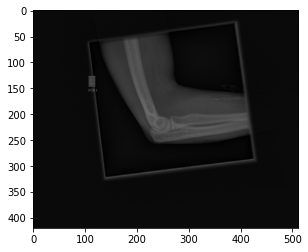

In [ ]:
# one input one output


image= input(f"Input the Image \t")


def prepare(filepath):

    IMG_SIZE=224
    picture=cv2.imread(filepath)
    img=cv2.resize(picture,(IMG_SIZE,IMG_SIZE))
    img = img.astype('float32')
    img=img_to_array(img)
    img /= 255.0
    return img.reshape(-1,IMG_SIZE,IMG_SIZE,3)

print('Processing...')
model =load_model('/content/drive/MyDrive/AI/H5/densenet_mura_ensemble.h5')
class_predict= model.predict_on_batch(prepare(image))
print(class_predict)
plt.imshow(cv2.imread(image))
if class_predict>= 0.5:
    stat = class_predict[0] * 100 
    print(f"This image is POSITIVE")
else:
    stat = class_predict[0] * 100 
    print(f"This image is  NEGATIVE")
           

#F

In [ ]:
#pic = '/content/MURA-v1.1/valid/XR_WRIST/patient11202/study1_positive/image1.png'
pic = '/content/MURA-v1.1/train/XR_SHOULDER/patient00003/study1_positive/image1.png'
#pic = '/content/MURA-v1.1/train/XR_FINGER/patient00169/study1_negative/image1.png'
picture=cv2.imread(pic)
img=cv2.resize(picture,IMAGE_SIZE)
img = img.astype('float32')
img=img_to_array(img)
img /= 255.0
img = np.expand_dims(img, 0)
result = []
for i in models:
    result = []
    index=0

    model = load_model(models[index])
    prediction= model.predict(prepare(image))

    #y_pred = np.argmax(Y_pred, axis=1).tolist()
    print(f"loadding model {index} : {models[index]} prediction {prediction}")
    c+=1

    result.append(prediction)

print(result)


loadding model 0 : /content/drive/MyDrive/AI/H5/Wrist.h5 prediction [[0.1788402]]


NameError: ignored

# Ensemble

italicized text# Abnormality Detection in Musculoskeletal Radiographs

Author: Rajkumar Shanmuganathan

 The objective is to build a machine learning model that can detect an abnormality in the X-Ray radiographs. These models can help towards providing healthcare access to the parts of the world where access to skilled radiologists is limited. According to a study on the Global Burden of Disease and the worldwide impact of all diseases found that, “musculoskeletal conditions affect more than 1.7 billion people worldwide. They are the 2nd greatest cause of disabilities, and have the 4th greatest impact on the overall health of the world population when considering both death and disabilities”. (www.usbji.org, n.d.).

This project attempts to implement deep neural network using DenseNet169 inspired from the Stanford Paper Rajpurkar, et al., 2018.

## Phase 4: Ensemble

I am planning to ensemble the models i built in the previous phases for each study types by generating the final output of the ensemble from the average output of all 7 models combined.

In [ ]:
from keras.applications.densenet import DenseNet169, DenseNet121, preprocess_input
from keras.preprocessing.image import ImageDataGenerator, load_img, image
from keras.models import Sequential, Model, load_model, Input
from keras.layers import Conv2D, MaxPool2D
from keras.layers import Activation, Dropout, Flatten, Dense, average
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint, Callback
from keras import regularizers
import pandas as pd
from tqdm import tqdm
import os
import numpy as np
import random
from keras.optimizers import Adam
import keras.backend as K
import cv2
import matplotlib.pyplot as plt

In [ ]:
def ensemble(models, model_input):
    # collect outputs of models in a list
    yModels=[model(model_input) for model in models] 
    # averaging outputs
    yAvg=average(yModels) 
    # build model from same input and avg output
    modelEns = Model(inputs=model_input, outputs=yAvg,    name='ensemble')  
   
    return modelEns

In [ ]:
models=[]
model_elbow = load_model("/content/drive/MyDrive/AI/H5/ELBOW_dansenet169_mura.h5")
model_elbow._name = 'model_elbow'
model_finger = load_model("/content/drive/MyDrive/AI/H5/FINGER_dansenet169.h5")
model_finger._name = 'model_finger'
model_forearm = load_model("/content/drive/MyDrive/AI/H5/FOREARM_DenseNet169_80%.h5")
model_forearm._name = 'model_forearm'
# model_hand = load_model("/content/drive/MyDrive/AI/H5/Hand_Den169.h5")
# model_hand._name = 'model_hand'
model_shoulder = load_model("/content/drive/MyDrive/AI/H5/SHOULDER_mura_densnet.h5",compile=False)
model_shoulder._name = 'model_shoulder'
model_wrist = load_model("/content/drive/MyDrive/AI/H5/Wrist.h5")
model_wrist._name = 'model_wrist'
model_humerus = load_model("/content/drive/MyDrive/AI/H5/HUMERUS_DensNet.h5",compile=False)
model_humerus._name = 'model_humerus'

models.append(model_elbow)
models.append(model_finger)
models.append(model_forearm)
#models.append(model_hand)
models.append(model_shoulder)
models.append(model_wrist)
models.append(model_humerus)


In [ ]:
model_input = Input(shape=models[0].input_shape[1:]) # c*h*w
modelEns = ensemble(models, model_input)

In [ ]:
modelEns.summary()

Model: "ensemble"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, None, None,  0                                            
__________________________________________________________________________________________________
model_elbow (Sequential)        (None, 1)            12672869    input_1[0][0]                    
__________________________________________________________________________________________________
model_finger (Sequential)       (None, 1)            12672869    input_1[0][0]                    
__________________________________________________________________________________________________
model_forearm (Sequential)      (None, 1)            13495873    input_1[0][0]                    
___________________________________________________________________________________________

In [ ]:
#modelEns.save("densenet_mura_ensemble.h5")

## 4.1 Evaluation

### 4.1.1 Creating a csv file containing path to image & csv

In [ ]:
def create_images_metadata_csv(category,study_types):
    """
    This function creates a csv file containing the path of images, label.
    """
    image_data = {}
    study_label = {'positive': 1, 'negative': 0}
    #study_types = ['XR_ELBOW','XR_FINGER','XR_FOREARM','XR_HAND','XR_HUMERUS','XR_SHOULDER','XR_WRIST']
    #study_types = ['XR_ELBOW']
    i = 0
    image_data[category] = pd.DataFrame(columns=['Path','Count', 'Label'])
    for study_type in study_types: # Iterate throught every study types
        DATA_DIR = '/content/MURA-v1.1/%s/%s/' % (category, study_type)
        patients = list(os.walk(DATA_DIR))[0][1]  # list of patient folder names
        for patient in tqdm(patients):  # for each patient folder
            for study in os.listdir(DATA_DIR + patient):  # for each study in that patient folder
                if(study != '.DS_Store'):
                    label = study_label[study.split('_')[1]]  # get label 0 or 1
                    path = DATA_DIR + patient + '/' + study + '/'  # path to this study
                    for j in range(len(list(listdir_nohidden(path)))):
                        image_path = path + 'image%s.png' % (j + 1)
                        image_data[category].loc[i] = [image_path,1, label]  # add new row
                        i += 1
    image_data[category].to_csv(category+"_image_data.csv",index = None, header=False)

In [ ]:
#New function create image array by study level
def getImagesInArrayNew(train_dataframe):
    images = []
    labels = []
    for i, data in tqdm(train_dataframe.iterrows()):
        img = cv2.imread(data['Path'])
#         #random rotation
#         angle = random.randint(-30,30)
#         M = cv2.getRotationMatrix2D((img_width/2,img_height/2),angle,1)
#         img = cv2.warpAffine(img,M,(img_width,img_height))
        #resize
        img = cv2.resize(img,(img_width,img_height))    
        img = img[...,::-1].astype(np.float32)
        images.append(img)
        labels.append(data['Label'])
    images = np.asarray(images).astype('float32') 
    #normalization
    mean = np.mean(images[:, :, :])
    std = np.std(images[:, :, :])
    images[:, :, :] = (images[:, :, :] - mean) / std
    labels = np.asarray(labels)
    return {'images': images, 'labels': labels}

In [ ]:
img_width, img_height = 224, 224
#Keras ImageDataGenerator to load, transform the images of the dataset
BASE_DATA_DIR = '/content/'
IMG_DATA_DIR = 'MURA-v1.1/'

In [ ]:
#Utility function to find the list of files in a directory excluding the hidden files.
def listdir_nohidden(path):
    for f in os.listdir(path):
        if not f.startswith('.'):
            yield f

In [ ]:
modelEns = load_model("/content/drive/MyDrive/AI/H5/densenet_mura_ensemble.h5")

## XR_FOREARM

In [ ]:
valid_data_dir = BASE_DATA_DIR + IMG_DATA_DIR + 'valid/XR_FOREARM'

test_datagen = ImageDataGenerator(
    rotation_range=30,
    horizontal_flip=True

)

study_types = ['XR_FOREARM']

create_images_metadata_csv('valid',study_types)

valid_image_df = pd.read_csv('valid_image_data.csv', names=['Path','Count', 'Label'])

dd={}

dd['valid'] = valid_image_df

valid_dict = getImagesInArrayNew(valid_image_df)

test_datagen.fit(valid_dict['images'],augment=True)

validation_generator = test_datagen.flow(
    x=valid_dict['images'],
    y=valid_dict['labels'],
    batch_size = 1
)


100%|██████████| 129/129 [00:00<00:00, 159.90it/s]
301it [00:01, 249.26it/s]


### 4.1.2 Performance Evaluation of XR_FOREARM

In [ ]:
#model parameters for training
#K.set_learning_phase(1)
nb_validation_samples = len(valid_dict['images'][:300])
epochs = 10
batch_size = 8
n_classes = 1
#pred = model.predict_generator(validation_generator, steps=1, batch_size=1, use_multiprocessing=False, max_queue_size=25, verbose=1)
validation_generator.reset()
#pred = model.predict_generator(validation_generator,steps=nb_validation_samples)
pred_batch = modelEns.predict_on_batch(valid_dict['images'][:300])

predictions = []
for p in pred_batch:
    if(p > 0.5):
        predictions+=[1]
    else:
        predictions+=[0]

error = np.sum(np.not_equal(predictions, valid_dict['labels'][:300])) / valid_dict['labels'][:300].shape[0]  
pred = predictions

In [ ]:
error

0.4533333333333333

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report, cohen_kappa_score
cohen_kappa_score(valid_dict['labels'][:300], pred)

0.09333333333333338

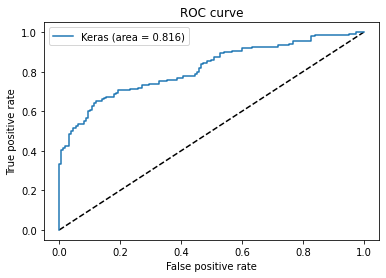

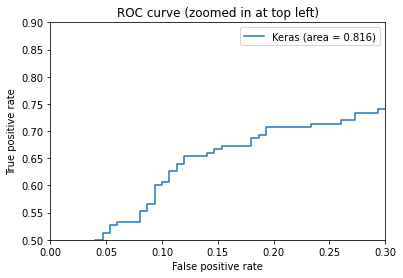

In [ ]:
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
fpr_keras, tpr_keras, thresholds_keras = roc_curve(valid_dict['labels'][:300], pred_batch)
auc_keras = auc(fpr_keras, tpr_keras)
plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_keras, tpr_keras, label='Keras (area = {:.3f})'.format(auc_keras))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

plt.figure(2)
plt.xlim(0.0, 0.3)
plt.ylim(0.5, 0.9)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_keras, tpr_keras, label='Keras (area = {:.3f})'.format(auc_keras))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve (zoomed in at top left)')
plt.legend(loc='best')
plt.show()

In [ ]:
print()
print('Classification Report')
print(classification_report(valid_dict['labels'][:300], pred, target_names=["0","1"]))


Classification Report
              precision    recall  f1-score   support

           0       0.52      1.00      0.69       150
           1       1.00      0.09      0.17       150

    accuracy                           0.55       300
   macro avg       0.76      0.55      0.43       300
weighted avg       0.76      0.55      0.43       300



## XR_ELBOW

In [ ]:
valid_data_dir = BASE_DATA_DIR + IMG_DATA_DIR + 'valid/XR_ELBOW'

test_datagen = ImageDataGenerator(
    rotation_range=30,
    horizontal_flip=True

)

study_types = ['XR_ELBOW']

create_images_metadata_csv('valid',study_types)

valid_image_df = pd.read_csv('valid_image_data.csv', names=['Path','Count', 'Label'])

dd={}

dd['valid'] = valid_image_df

valid_dict = getImagesInArrayNew(valid_image_df)

test_datagen.fit(valid_dict['images'],augment=True)

validation_generator = test_datagen.flow(
    x=valid_dict['images'],
    y=valid_dict['labels'],
    batch_size = 1
)


100%|██████████| 152/152 [00:01<00:00, 139.45it/s]
465it [00:01, 250.34it/s]


### 4.1.2 Performance Evaluation of XR_ELBOW

In [ ]:
#model parameters for training
#K.set_learning_phase(1)
nb_validation_samples = len(valid_dict['images'][:300])
epochs = 10
batch_size = 8
n_classes = 1
#pred = model.predict_generator(validation_generator, steps=1, batch_size=1, use_multiprocessing=False, max_queue_size=25, verbose=1)
validation_generator.reset()
#pred = model.predict_generator(validation_generator,steps=nb_validation_samples)
pred_batch = modelEns.predict_on_batch(valid_dict['images'][:300])

predictions = []
for p in pred_batch:
    if(p > 0.5):
        predictions+=[1]
    else:
        predictions+=[0]

error = np.sum(np.not_equal(predictions, valid_dict['labels'][:300])) / valid_dict['labels'][:300].shape[0]  
pred = predictions

In [ ]:
error

0.20333333333333334

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report, cohen_kappa_score
cohen_kappa_score(valid_dict['labels'][:300], pred)

0.5935501066098081

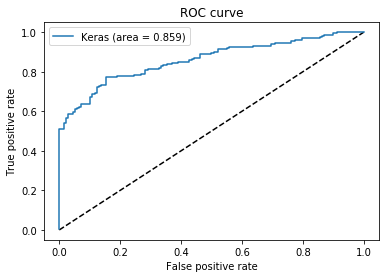

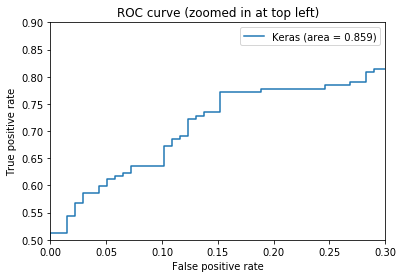

In [ ]:
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
fpr_keras, tpr_keras, thresholds_keras = roc_curve(valid_dict['labels'][:300], pred_batch)
auc_keras = auc(fpr_keras, tpr_keras)
plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_keras, tpr_keras, label='Keras (area = {:.3f})'.format(auc_keras))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

plt.figure(2)
plt.xlim(0.0, 0.3)
plt.ylim(0.5, 0.9)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_keras, tpr_keras, label='Keras (area = {:.3f})'.format(auc_keras))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve (zoomed in at top left)')
plt.legend(loc='best')
plt.show()

In [ ]:
print()
print('Classification Report')
print(classification_report(valid_dict['labels'][:300], pred, target_names=["0","1"]))


Classification Report
             precision    recall  f1-score   support

          0       0.75      0.83      0.79       138
          1       0.84      0.77      0.80       162

avg / total       0.80      0.80      0.80       300



## XR_WRIST

In [ ]:
valid_data_dir = BASE_DATA_DIR + IMG_DATA_DIR + 'valid/XR_WRIST'

test_datagen = ImageDataGenerator(
    rotation_range=30,
    horizontal_flip=True

)

study_types = ['XR_WRIST']

create_images_metadata_csv('valid',study_types)

valid_image_df = pd.read_csv('valid_image_data.csv', names=['Path','Count', 'Label'])

dd={}

dd['valid'] = valid_image_df

valid_dict = getImagesInArrayNew(valid_image_df)

test_datagen.fit(valid_dict['images'],augment=True)

validation_generator = test_datagen.flow(
    x=valid_dict['images'],
    y=valid_dict['labels'],
    batch_size = 1
)


100%|██████████| 207/207 [00:01<00:00, 134.40it/s]
659it [00:02, 255.99it/s]


### 4.1.2 Performance Evaluation of XR_WRIST

In [ ]:
#model parameters for training
#K.set_learning_phase(1)
nb_validation_samples = len(valid_dict['images'][:300])
epochs = 10
batch_size = 8
n_classes = 1
#pred = model.predict_generator(validation_generator, steps=1, batch_size=1, use_multiprocessing=False, max_queue_size=25, verbose=1)
validation_generator.reset()
#pred = model.predict_generator(validation_generator,steps=nb_validation_samples)
pred_batch = modelEns.predict_on_batch(valid_dict['images'][:300])

predictions = []
for p in pred_batch:
    if(p > 0.5):
        predictions+=[1]
    else:
        predictions+=[0]

error = np.sum(np.not_equal(predictions, valid_dict['labels'][:300])) / valid_dict['labels'][:300].shape[0]  
pred = predictions

In [ ]:
error

0.24666666666666667

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report, cohen_kappa_score
cohen_kappa_score(valid_dict['labels'][:300], pred)

0.5103445233578896

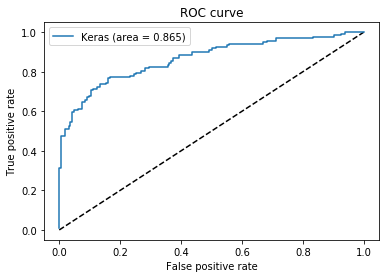

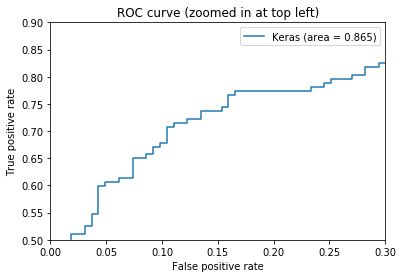

In [ ]:
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
fpr_keras, tpr_keras, thresholds_keras = roc_curve(valid_dict['labels'][:300], pred_batch)
auc_keras = auc(fpr_keras, tpr_keras)
plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_keras, tpr_keras, label='Keras (area = {:.3f})'.format(auc_keras))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

plt.figure(2)
plt.xlim(0.0, 0.3)
plt.ylim(0.5, 0.9)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_keras, tpr_keras, label='Keras (area = {:.3f})'.format(auc_keras))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve (zoomed in at top left)')
plt.legend(loc='best')
plt.show()

## XR_HUMERUS

In [ ]:
valid_data_dir = BASE_DATA_DIR + IMG_DATA_DIR + 'valid/XR_HUMERUS'

test_datagen = ImageDataGenerator(
    rotation_range=30,
    horizontal_flip=True

)

study_types = ['XR_HUMERUS']

create_images_metadata_csv('valid',study_types)

valid_image_df = pd.read_csv('valid_image_data.csv', names=['Path','Count', 'Label'])

dd={}

dd['valid'] = valid_image_df

valid_dict = getImagesInArrayNew(valid_image_df)

test_datagen.fit(valid_dict['images'],augment=True)

validation_generator = test_datagen.flow(
    x=valid_dict['images'],
    y=valid_dict['labels'],
    batch_size = 1
)


100%|██████████| 132/132 [00:00<00:00, 198.89it/s]
288it [00:01, 249.26it/s]


### 4.1.2 Performance Evaluation of XR_HUMERUS

In [ ]:
#model parameters for training
#K.set_learning_phase(1)
nb_validation_samples = len(valid_dict['images'][:300])
epochs = 10
batch_size = 8
n_classes = 1
#pred = model.predict_generator(validation_generator, steps=1, batch_size=1, use_multiprocessing=False, max_queue_size=25, verbose=1)
validation_generator.reset()
#pred = model.predict_generator(validation_generator,steps=nb_validation_samples)
pred_batch = modelEns.predict_on_batch(valid_dict['images'][:300])

predictions = []
for p in pred_batch:
    if(p > 0.5):
        predictions+=[1]
    else:
        predictions+=[0]

error = np.sum(np.not_equal(predictions, valid_dict['labels'][:300])) / valid_dict['labels'][:300].shape[0]  
pred = predictions

In [ ]:
error

0.2326388888888889

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report, cohen_kappa_score
cohen_kappa_score(valid_dict['labels'][:300], pred)

0.5362430301865027

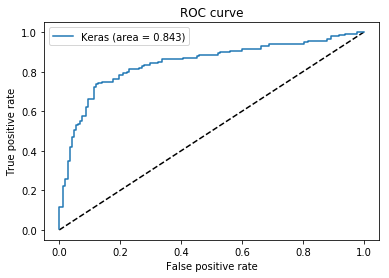

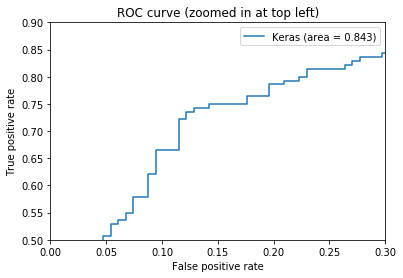

In [ ]:
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
fpr_keras, tpr_keras, thresholds_keras = roc_curve(valid_dict['labels'][:300], pred_batch)
auc_keras = auc(fpr_keras, tpr_keras)
plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_keras, tpr_keras, label='Keras (area = {:.3f})'.format(auc_keras))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

plt.figure(2)
plt.xlim(0.0, 0.3)
plt.ylim(0.5, 0.9)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_keras, tpr_keras, label='Keras (area = {:.3f})'.format(auc_keras))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve (zoomed in at top left)')
plt.legend(loc='best')
plt.show()

## XR_FINGER

In [ ]:
valid_data_dir = BASE_DATA_DIR + IMG_DATA_DIR + 'valid/XR_FINGER'

test_datagen = ImageDataGenerator(
    rotation_range=30,
    horizontal_flip=True

)

study_types = ['XR_FINGER']

create_images_metadata_csv('valid',study_types)

valid_image_df = pd.read_csv('valid_image_data.csv', names=['Path','Count', 'Label'])

dd={}

dd['valid'] = valid_image_df

valid_dict = getImagesInArrayNew(valid_image_df)

test_datagen.fit(valid_dict['images'],augment=True)

validation_generator = test_datagen.flow(
    x=valid_dict['images'],
    y=valid_dict['labels'],
    batch_size = 1
)


100%|██████████| 166/166 [00:01<00:00, 155.53it/s]
461it [00:01, 287.88it/s]


### 4.1.2 Performance Evaluation of XR_FINGER

In [ ]:
#model parameters for training
#K.set_learning_phase(1)
nb_validation_samples = len(valid_dict['images'][:300])
epochs = 10
batch_size = 8
n_classes = 1
#pred = model.predict_generator(validation_generator, steps=1, batch_size=1, use_multiprocessing=False, max_queue_size=25, verbose=1)
validation_generator.reset()
#pred = model.predict_generator(validation_generator,steps=nb_validation_samples)
pred_batch = modelEns.predict_on_batch(valid_dict['images'][:300])

predictions = []
for p in pred_batch:
    if(p > 0.5):
        predictions+=[1]
    else:
        predictions+=[0]

error = np.sum(np.not_equal(predictions, valid_dict['labels'][:300])) / valid_dict['labels'][:300].shape[0]  
pred = predictions

In [ ]:
error

0.32666666666666666

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report, cohen_kappa_score
cohen_kappa_score(valid_dict['labels'][:300], pred)

0.3268306086000825

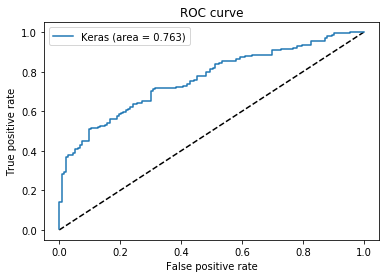

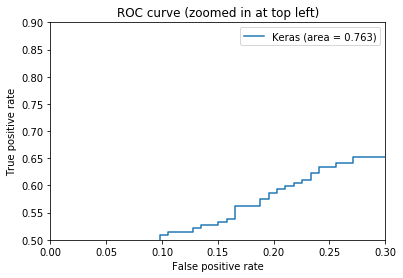

In [ ]:
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
fpr_keras, tpr_keras, thresholds_keras = roc_curve(valid_dict['labels'][:300], pred_batch)
auc_keras = auc(fpr_keras, tpr_keras)
plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_keras, tpr_keras, label='Keras (area = {:.3f})'.format(auc_keras))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

plt.figure(2)
plt.xlim(0.0, 0.3)
plt.ylim(0.5, 0.9)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_keras, tpr_keras, label='Keras (area = {:.3f})'.format(auc_keras))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve (zoomed in at top left)')
plt.legend(loc='best')
plt.show()

## XR_HAND

In [ ]:
valid_data_dir = BASE_DATA_DIR + IMG_DATA_DIR + 'valid/XR_HAND'

test_datagen = ImageDataGenerator(
    rotation_range=30,
    horizontal_flip=True

)

study_types = ['XR_HAND']

create_images_metadata_csv('valid',study_types)

valid_image_df = pd.read_csv('valid_image_data.csv', names=['Path','Count', 'Label'])

dd={}

dd['valid'] = valid_image_df

valid_dict = getImagesInArrayNew(valid_image_df)

test_datagen.fit(valid_dict['images'],augment=True)

validation_generator = test_datagen.flow(
    x=valid_dict['images'],
    y=valid_dict['labels'],
    batch_size = 1
)


100%|██████████| 159/159 [00:01<00:00, 147.03it/s]
460it [00:01, 246.70it/s]


### 4.1.2 Performance Evaluation of XR_HAND

In [ ]:
#model parameters for training
#K.set_learning_phase(1)
nb_validation_samples = len(valid_dict['images'][:300])
epochs = 10
batch_size = 8
n_classes = 1
#pred = model.predict_generator(validation_generator, steps=1, batch_size=1, use_multiprocessing=False, max_queue_size=25, verbose=1)
validation_generator.reset()
#pred = model.predict_generator(validation_generator,steps=nb_validation_samples)
pred_batch = modelEns.predict_on_batch(valid_dict['images'][:300])

predictions = []
for p in pred_batch:
    if(p > 0.5):
        predictions+=[1]
    else:
        predictions+=[0]

error = np.sum(np.not_equal(predictions, valid_dict['labels'][:300])) / valid_dict['labels'][:300].shape[0]  
pred = predictions

In [ ]:
error

0.3933333333333333

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report, cohen_kappa_score
cohen_kappa_score(valid_dict['labels'][:300], pred)

0.15906499429874565

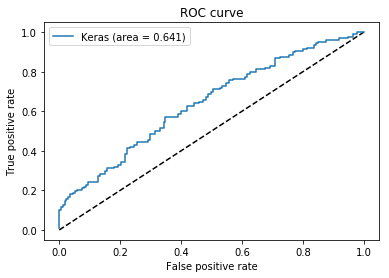

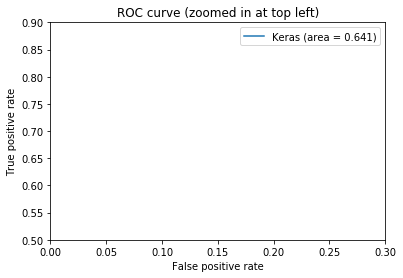

In [ ]:
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
fpr_keras, tpr_keras, thresholds_keras = roc_curve(valid_dict['labels'][:300], pred_batch)
auc_keras = auc(fpr_keras, tpr_keras)
plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_keras, tpr_keras, label='Keras (area = {:.3f})'.format(auc_keras))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

plt.figure(2)
plt.xlim(0.0, 0.3)
plt.ylim(0.5, 0.9)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_keras, tpr_keras, label='Keras (area = {:.3f})'.format(auc_keras))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve (zoomed in at top left)')
plt.legend(loc='best')
plt.show()

## XR_SHOULDER

In [ ]:
valid_data_dir = BASE_DATA_DIR + IMG_DATA_DIR + 'valid/XR_SHOULDER'

test_datagen = ImageDataGenerator(
    rotation_range=30,
    horizontal_flip=True

)

study_types = ['XR_SHOULDER']

create_images_metadata_csv('valid',study_types)

valid_image_df = pd.read_csv('valid_image_data.csv', names=['Path','Count', 'Label'])

dd={}

dd['valid'] = valid_image_df

valid_dict = getImagesInArrayNew(valid_image_df)

test_datagen.fit(valid_dict['images'],augment=True)

validation_generator = test_datagen.flow(
    x=valid_dict['images'],
    y=valid_dict['labels'],
    batch_size = 1
)


100%|██████████| 173/173 [00:01<00:00, 114.96it/s]
563it [00:02, 226.50it/s]


### 4.1.2 Performance Evaluation of XR_SHOULDER

In [ ]:
#model parameters for training
#K.set_learning_phase(1)
nb_validation_samples = len(valid_dict['images'][:300])
epochs = 10
batch_size = 8
n_classes = 1
#pred = model.predict_generator(validation_generator, steps=1, batch_size=1, use_multiprocessing=False, max_queue_size=25, verbose=1)
validation_generator.reset()
#pred = model.predict_generator(validation_generator,steps=nb_validation_samples)
pred_batch = modelEns.predict_on_batch(valid_dict['images'][:300])

predictions = []
for p in pred_batch:
    if(p > 0.5):
        predictions+=[1]
    else:
        predictions+=[0]

error = np.sum(np.not_equal(predictions, valid_dict['labels'][:300])) / valid_dict['labels'][:300].shape[0]  
pred = predictions

In [ ]:
error

0.4633333333333333

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report, cohen_kappa_score
cohen_kappa_score(valid_dict['labels'][:300], pred)

0.050546448087431695

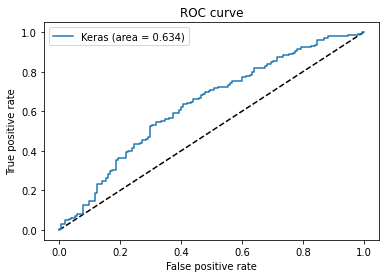

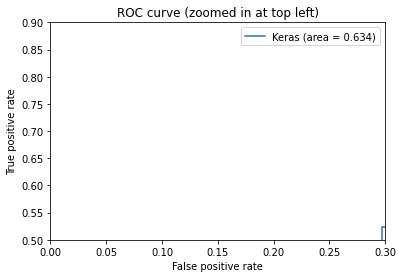

In [ ]:
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
fpr_keras, tpr_keras, thresholds_keras = roc_curve(valid_dict['labels'][:300], pred_batch)
auc_keras = auc(fpr_keras, tpr_keras)
plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_keras, tpr_keras, label='Keras (area = {:.3f})'.format(auc_keras))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

plt.figure(2)
plt.xlim(0.0, 0.3)
plt.ylim(0.5, 0.9)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_keras, tpr_keras, label='Keras (area = {:.3f})'.format(auc_keras))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve (zoomed in at top left)')
plt.legend(loc='best')
plt.show()

# TEST


In [ ]:
!pip install fastapi 
!pip install uvicorn
!pip install python-multipart

  Created wheel for python-multipart: filename=python_multipart-0.0.5-cp37-none-any.whl size=31677 sha256=e4abd0f4c3215eabb7f1e4332761085aeb78e3e36cd40bb4d3ce536fb4462dbc
  Stored in directory: /root/.cache/pip/wheels/f0/e6/66/14a866a3cbd6a0cabfbef91f7edf40aa03595ef6c88d6d1be4
Successfully built python-multipart


In [ ]:
!pip install pyngrok

     |████████████████████████████████| 747kB 32.4MB/s 
  Created wheel for pyngrok: filename=pyngrok-5.0.5-cp37-none-any.whl size=19262 sha256=1aca700bc6068fa303ae8c427d5d939eab23e0615823fab935aa594da2a4687e
  Stored in directory: /root/.cache/pip/wheels/0c/13/64/5ebbcc22eaf53fdf5766b397c1fb17c83f5775fdccf0ea1b88
Successfully built pyngrok


In [ ]:
from fastapi.encoders import jsonable_encoder
import matplotlib.image as mpimg
import numpy as np
import cv2
import shutil
from io import BytesIO
from PIL import Image
from numpy.lib.type_check import imag
import tensorflow as tf 
import cv2 
import matplotlib.pyplot as plt
from PIL import Image
import skimage
from tensorflow.keras.models import load_model
from fastapi import FastAPI
import uvicorn
from fastapi import UploadFile, File
from tensorflow.keras.preprocessing.image import  img_to_array
import os
from pathlib import Path


app = FastAPI()
@app.get("/")
async def index():
    return {"Hello": "World"}


def prepare(filepath):
    IMG_SIZE=224
    picture = cv2.imread(filepath,1)
    print(picture)
    img=cv2.resize(picture,(IMG_SIZE,IMG_SIZE))
    img = img.astype('float32')
    img=img_to_array(img)
    img /= 255.0
    return img.reshape(-1,IMG_SIZE,IMG_SIZE,3)



def predict_by_category(image,class_input):

    class_names = ['wrist', 'shoulder', 'hand',
                   'finger', 'elbow', 'forearm', 'humerus']

    models = ["WRIST.h5",
              "SHOULDER.h5",
              "HAND.h5",
              "FINGER.h5",
              "ELBOW.h5",
              "FOREARM.h5",
              "HUMERUS.h5"
              ]
    for i in class_names:
          
        index = 0
        if class_input == i:
            print('Processing...')
            model = load_model(models[index])
            class_predict = model.predict_on_batch(prepare(image))
            print(class_predict)
           
            if class_predict >= 0.5:
                stat = class_predict[0] * 100
                print(stat)
                prediction = "This image  ABNORMAL"

            else:
                stat = class_predict[0] * 100
                print(stat)
                prediction = "This image is  NORMAL"

            index += 1
        else:
            pass
        
    return prediction


# Current directory (relative):
cwd = Path()  # or Path('.')
print(cwd)

# Current directory (absolute):
cwd = Path.cwd()
print(cwd)

# User home directory:
home = Path.home()
print(home)

def predict_ensemble(image):

    
    print('Processing...')

    model = load_model(f'densenet_mura_ensemble.h5')
    class_predict = model.predict_on_batch(prepare(image))
    #print(class_predict)
    if class_predict >= 0.5:
        stat = class_predict[0] * 100
        prediction = "This image is ABNORMAL"
    else:
        stat = class_predict[0] * 100
        prediction = "This image is  NORMAL"

    return prediction 


@app.post('/api/predict_ensemble')
async def predict_image(file: UploadFile = File(...)):

    with open("img.png", "wb") as buffer:
        shutil.copyfileobj(file.file, buffer)



    prediction= predict_ensemble('img.png')
    return prediction



@app.post('/api/predict_by_category')
async def predict_image_by_category(class_input :str,file: UploadFile = File(...) ):
   
    
   
    print(class_input)

    with open("img.png", "wb") as buffer:
        shutil.copyfileobj(file.file, buffer)

    prediction= predict_by_category('img.png',class_input)
    return prediction 



from pyngrok import ngrok

ngrok_tunnel = ngrok.connect(8090)
print('public URL : ',ngrok_tunnel.public_url )
uvicorn.run(app, port=8090)








t=2021-07-04T15:26:54+0000 lvl=warn msg="failed to start tunnel" pg=/api/tunnels id=085ab1dff0f3af2e err="Your account may not run more than 2 tunnels over a single ngrok client session.\nThe tunnels already running on this session are:\ntn_1ur8TUhM6kcg7zrZRzbE4jxvBf9, tn_1ur8TONxPB22dcVXTQOvkkYwF8b\n\r\n\r\nERR_NGROK_324\r\n"


.
/content
/root


PyngrokNgrokHTTPError: ignored